# Chapter 5

In [2]:
library(MASS)

## be careful to load dplyr after MASS
library(dplyr)
library(tidyr)
library(purrr)
library(extraDistr)
library(ggplot2)
library(loo)
library(bridgesampling)
library(brms)
library(bayesplot)
library(tictoc)
library(hypr)
library(bcogsci)
library(lme4)
library(rstan)
library(rootSolve)


Dolaczanie pakietu: 'dplyr'


Nastepujacy obiekt zostal zakryty z 'package:MASS':

    select


Nastepujace obiekty zostaly zakryte z 'package:stats':

    filter, lag


Nastepujace obiekty zostaly zakryte z 'package:base':

    intersect, setdiff, setequal, union



Dolaczanie pakietu: 'extraDistr'


Nastepujacy obiekt zostal zakryty z 'package:purrr':

    rdunif


This is loo version 2.5.1

- Online documentation and vignettes at mc-stan.org/loo

- As of v2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) for an entire session. 

Ladowanie wymaganego pakietu: Rcpp

Loading 'brms' package (version 2.17.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Dolaczanie pakietu: 'brms'


Nastepujacy obiekt zostal zakryty z 'package:bridgesampling':

    bf


Nastepujace obiekty zostaly zakryte z 'package:

In [3]:
## Save compiled models:
rstan_options(auto_write = FALSE)
## Parallelize the chains using all the cores:
options(mc.cores = parallel::detectCores())
# To solve some conflicts between packages
select <- dplyr::select
extract <- rstan::extract

## Exchangeability and a first hierarchical model

In [ ]:
N_subj <- 20
N_obs_subj <- 50
N <- N_subj * N_obs_subj
df <- tibble(row = 1:N,
             subj = rep(c(1:N_subj), each = N_obs_subj))
df

In [ ]:
mu <- 100
tau <- 15
sigma <- 4
mu_i <- rnorm(N_subj, mu, tau)
df_h <- mutate(df, y = rnorm(N, mu_i[subj], sigma))
df_h 

In [6]:
fit_h <- brm(y ~ 1 + (1 | subj), df_h,
             prior =
               c(prior(normal(50, 200), class = Intercept),
                 prior(normal(2, 5), class = sigma),
                 prior(normal(10, 20), class = sd)),
             # increase iterations to avoid convergence issues
             iter = 4000,
             warmup = 1000)

Compiling Stan program...

Warning message in FUN(X[[i]], ...):
"tekst niereprezentowalny w natywnym kodowaniu bedzie przetlumaczony na UTF-8"
Start sampling



In [7]:
fit_h

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: y ~ 1 + (1 | subj) 
   Data: df_h (Number of observations: 1000) 
  Draws: 4 chains, each with iter = 4000; warmup = 1000; thin = 1;
         total post-warmup draws = 12000

Group-Level Effects: 
~subj (Number of levels: 20) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)    15.21      2.59    11.10    21.30 1.01      771     1434

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept    97.47      3.31    91.09   103.99 1.01      630      784

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     4.10      0.09     3.93     4.29 1.00     2024     2450

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

In [10]:
# Extract the posterior estimates of u_i
u_i_post <- as_draws_df(fit_h) %>%
  select(starts_with("r_subj"))
# Extract the posterior estimate of mu
mu_post <- as_draws_df(fit_h)$b_Intercept 
# Build the posterior estimate of mu_i
mu_i_post <- mu_post + u_i_post
colMeans(mu_i_post) %>% unname()

Warning message:
“Dropping 'draws_df' class as required metadata was removed.”


[1] 115.20771 115.99776 103.63608 116.42776  90.57454  91.61110 101.78983
 [8]  97.83965  95.30365  73.75190 110.10437 117.01756  88.59501  86.13932
[15]  80.11437  70.79045 139.53221  97.77074 105.30722  83.90153

In [11]:
# Compare with true values
mu_i

[1] 114.36820 115.86422 102.79792 116.84638  90.97480  92.22252 100.98721
 [8]  96.38712  94.93598  74.61606 109.58337 116.98899  89.00798  85.79946
[15]  80.66265  70.49138 140.23379  98.20507 104.73128  83.40240

## A hierarchical model with a normal likelihood: The N400 effect

In [8]:
# load data
data("df_eeg")

In [9]:
head(df_eeg)

subj cloze item n400  cloze_ans N 
1 1    0.00  1     7.08  0        44
2 1    0.03  2    -0.68  1        44
3 1    1.00  3     1.39 44        44
4 1    0.93  4    22.78 41        44
5 1    0.00  5     1.61  0        44
6 1    0.00  6     3.01  0        44

In [10]:
# center the cloze probability variable before using it as a predictor
df_eeg <- df_eeg %>%
  mutate(c_cloze = cloze - mean(cloze))

In [11]:
# Number of subjects
df_eeg %>%
  distinct(subj) %>%
  count()

n 
1 37

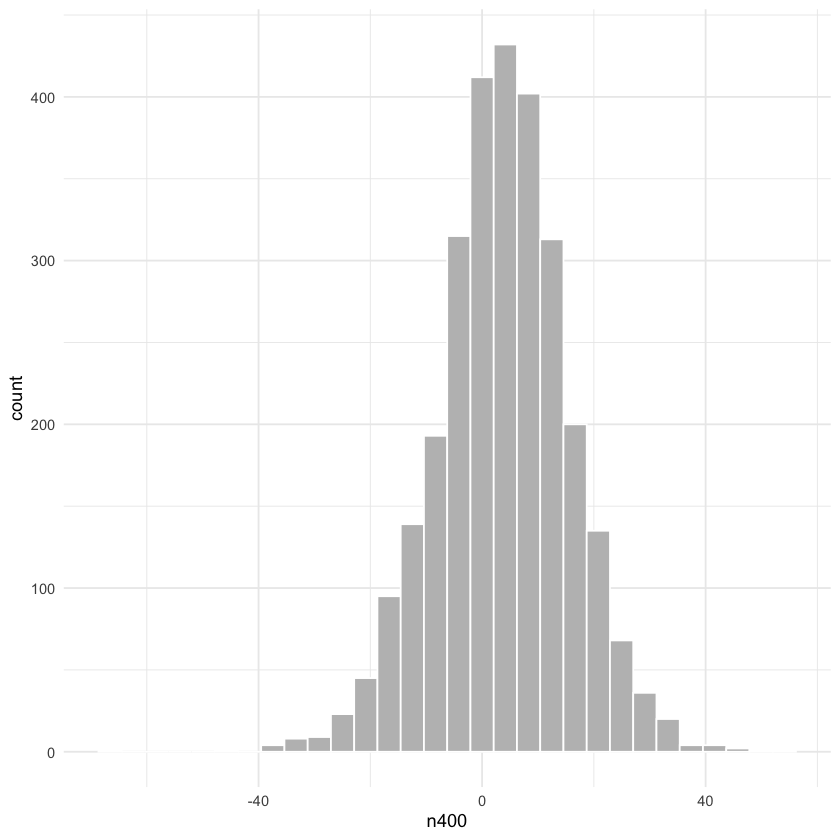

In [12]:
ggplot(df_eeg, aes(x=n400)) + theme_minimal() + geom_histogram(bins=30, color="white", fill="grey")

### Complete pooling model (simple regression)

This model makes the following assumptions:

1. The EEG averages for the N400 spatiotemporal window are normally distributed.
2. Observations are independent.
3. There is a linear relationship between cloze and the EEG signal for the trial.

This model is incorrect for these data due to **assumption (2) being violated**.

#### Priors

A normal likelihood seems reasonable for these data:

In [43]:
# mean
qnorm(c(.025, .975), mean = 0, sd = 10)

# sigma - trunkated distribution
samples <- rtnorm(20000, mean = 0, sd = 50, a = 0)
quantile(samples, probs = c(0.025, .975))

# beta
qnorm(c(.025, .975), mean = 0, sd = 10)

[1] -19.59964  19.59964

2.5%      97.5% 
  1.594471 112.838693

[1] -19.59964  19.59964

#### Model

A model such as the one above is sometimes called a fixed-effects model: all the parameters are fixed in the sense that do not vary from subject to subject or from item to item.

In [6]:
fit_N400_cp <- brm(n400 ~ 1 + c_cloze,
  prior =
    c(
      prior(normal(0, 10), class = Intercept),
      prior(normal(0, 10), class = b, coef = c_cloze),
      prior(normal(0, 50), class = sigma)
    ),
  data = df_eeg
)

Compiling Stan program...

Start sampling



In [7]:
fit_N400_cp

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: n400 ~ 1 + c_cloze 
   Data: df_eeg (Number of observations: 2863) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     3.66      0.22     3.24     4.10 1.00     4325     3262
c_cloze       2.24      0.54     1.22     3.32 1.00     4627     2485

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma    11.82      0.16    11.51    12.13 1.00     4826     3057

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

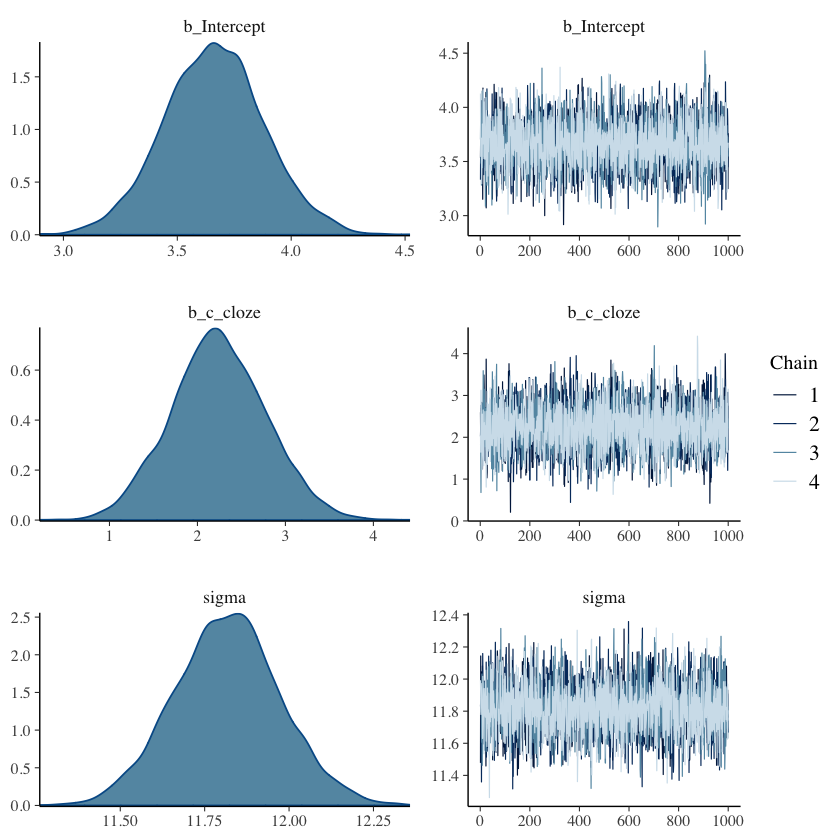

In [8]:
plot(fit_N400_cp)

### No pooling model

One of the assumptions of the previous model is clearly wrong: observations are not independent, they are clustered by subject. It is reasonable to assume that EEG signals are more similar within subjects than between them. The following model assumes that each subject is completely independent from each other.

Model assumptions:
1. EEG averages for the N400 spatio-temporal window are normally distributed.
2. Every subject’s model is fit independently of the other subjects; the subjects have no parameters in common (an exception is the standard deviation; this is the same for all subjects).
3. There is a linear relationship between cloze and the EEG signal for the trial.

#### Priors

Now, because we assume independence of subjects' data, we have **N means and N betas** (and sigma which could be the same for each model).
In brms, such a model can be fit by removing the common intercept with the formula n400 ~ 0 + factor(subj) + c_cloze:factor(subj).

This formula forces the model to estimate one intercept and one slope for each level of subj.15 The by-subject intercepts are indicated with factor(subj) and the by-subject slopes with c_cloze:factor(subj). It’s very important to specify that subject should be treated as a factor and not as a number. The model fits 37 independent intercepts and 37 independent slopes.

#### Model

In [4]:
fit_N400_np <- brm(n400 ~ 0 + factor(subj) + c_cloze:factor(subj),
  prior =
    c(
      prior(normal(0, 10), class = b),
      prior(normal(0, 50), class = sigma)
    ),
  data = df_eeg
)

ERROR: Error: The following variables can neither be found in 'data' nor in 'data2':
'c_cloze'


In [ ]:
fit_N400_np

The model $M_{np}$ does not estimate a unique population-level effect; instead, there is a different effect estimated for each subject.

Plot results by subject

In [53]:
# create subjects beta-variable's names - merge stings
ind_effects_np <- paste0(
  "b_factorsubj",
  unique(df_eeg$subj), ":c_cloze"
)
ind_effects_np

[1] "b_factorsubj1:c_cloze"  "b_factorsubj2:c_cloze"  "b_factorsubj3:c_cloze" 
 [4] "b_factorsubj4:c_cloze"  "b_factorsubj5:c_cloze"  "b_factorsubj6:c_cloze" 
 [7] "b_factorsubj7:c_cloze"  "b_factorsubj8:c_cloze"  "b_factorsubj9:c_cloze" 
[10] "b_factorsubj10:c_cloze" "b_factorsubj11:c_cloze" "b_factorsubj12:c_cloze"
[13] "b_factorsubj13:c_cloze" "b_factorsubj14:c_cloze" "b_factorsubj15:c_cloze"
[16] "b_factorsubj16:c_cloze" "b_factorsubj17:c_cloze" "b_factorsubj18:c_cloze"
[19] "b_factorsubj19:c_cloze" "b_factorsubj20:c_cloze" "b_factorsubj21:c_cloze"
[22] "b_factorsubj22:c_cloze" "b_factorsubj23:c_cloze" "b_factorsubj24:c_cloze"
[25] "b_factorsubj25:c_cloze" "b_factorsubj26:c_cloze" "b_factorsubj27:c_cloze"
[28] "b_factorsubj28:c_cloze" "b_factorsubj29:c_cloze" "b_factorsubj30:c_cloze"
[31] "b_factorsubj31:c_cloze" "b_factorsubj32:c_cloze" "b_factorsubj33:c_cloze"
[34] "b_factorsubj34:c_cloze" "b_factorsubj35:c_cloze" "b_factorsubj36:c_cloze"
[37] "b_factorsubj37:c_cloze"

In [67]:
beta_across_subj <- as_draws_df(fit_N400_np) %>% 
  # removes the meta data from the object
  as.data.frame() %>%
  select(all_of(ind_effects_np))  %>% # select only beta variables
      rowMeans() # calculate mean from subject for each posterior sample

In [68]:
# Calculate the average of these estimates
(grand_av_beta <- tibble(
  mean = mean(beta_across_subj), # mean of posterior samples from all subjects
  lq = quantile(beta_across_subj, c(.025)),
  hq = quantile(beta_across_subj, c(.975))
))

mean    lq       hq     
1 2.17786 1.181975 3.15212

In [101]:
# make a table of beta's by subject
beta_by_subj <- posterior_summary(fit_N400_np,
  variable = ind_effects_np
) %>%
  as.data.frame() %>%
  mutate(subject = 1:n()) %>% # add column with subject number
  
  ## reorder plot by magnitude of mean:
  arrange(Estimate) %>%
  mutate(subject = factor(subject, levels = subject))

beta_by_subj

Estimate    Est.Error Q2.5       Q97.5     subject
b_factorsubj25:c_cloze -3.34593703 3.111945  -9.4726967  2.763142 25     
b_factorsubj2:c_cloze  -2.31957984 3.326786  -8.7728094  4.166478 2      
b_factorsubj14:c_cloze -2.13183301 2.930620  -7.9896630  3.511519 14     
b_factorsubj1:c_cloze  -1.78128464 2.912843  -7.2863779  3.879116 1      
b_factorsubj16:c_cloze -1.76977627 3.257649  -8.1167583  4.656989 16     
b_factorsubj20:c_cloze -1.63014436 3.107689  -7.9628080  4.367727 20     
b_factorsubj22:c_cloze -1.34240418 2.860498  -6.9960054  4.205458 22     
b_factorsubj7:c_cloze  -1.11044812 3.196623  -7.3414395  5.028883 7      
b_factorsubj5:c_cloze  -1.04332981 3.055765  -6.8548345  5.070272 5      
b_factorsubj9:c_cloze  -0.75042271 2.910582  -6.3585959  5.066757 9      
b_factorsubj3:c_cloze  -0.42433655 3.213836  -6.7642415  5.904421 3      
b_factorsubj34:c_cloze -0.21186609 2.885784  -5.8660869  5.519703 34     
b_factorsubj27:c_cloze  0.08625089 3.262264  -6.3144927  6.372671 27     
b_factorsubj33:c_cloze  0.17490854 3.008070  -5.7196267  5.965890 33     
b_factorsubj26:c_cloze  0.58446430 3.066061  -5.4792788  6.699218 26     
b_factorsubj12:c_cloze  0.73865092 2.981038  -5.0902969  6.511035 12     
b_factorsubj32:c_cloze  1.82810931 3.147583  -4.2974005  8.061302 32     
b_factorsubj19:c_cloze  2.03150240 3.189307  -4.1270729  8.247871 19     
b_factorsubj29:c_cloze  2.37804866 3.053360  -3.7259216  8.403262 29     
b_factorsubj31:c_cloze  2.38272438 3.109427  -3.7013409  8.375150 31     
b_factorsubj18:c_cloze  2.38927453 3.169097  -3.8610690  8.603288 18     
b_factorsubj23:c_cloze  2.45434330 3.202991  -3.8201017  8.701150 23     
b_factorsubj17:c_cloze  2.65237070 3.238204  -3.5643533  8.968679 17     
b_factorsubj4:c_cloze   2.78718395 3.140224  -3.3883365  8.927434 4      
b_factorsubj11:c_cloze  2.84292100 3.130174  -3.1615412  8.954581 11     
b_factorsubj13:c_cloze  3.86651025 3.209882  -2.4001502 10.310617 13     
b_factorsubj15:c_cloze  4.50866220 3.255638  -1.8821806 10.969941 15     
b_factorsubj10:c_cloze  4.66301282 2.981632  -0.8790946 10.579975 10     
b_factorsubj24:c_cloze  4.84729399 3.126495  -1.2216939 10.797955 24     
b_factorsubj37:c_cloze  5.35868545 3.023909  -0.6810593 11.201907 37     
b_factorsubj30:c_cloze  5.95069777 3.139778  -0.2526335 11.968456 30     
b_factorsubj8:c_cloze   6.86686706 3.200535   0.5898570 13.170261 8      
b_factorsubj21:c_cloze  6.90622812 3.230597   0.6653748 13.364038 21     
b_factorsubj28:c_cloze  7.05457987 2.999042   1.3548463 12.879976 28     
b_factorsubj36:c_cloze  7.76734867 3.314521   1.2771323 14.191674 36     
b_factorsubj6:c_cloze   8.20603505 2.980793   2.3306073 14.045231 6      
b_factorsubj35:c_cloze  9.11552130 3.259797   2.8871250 15.445464 35

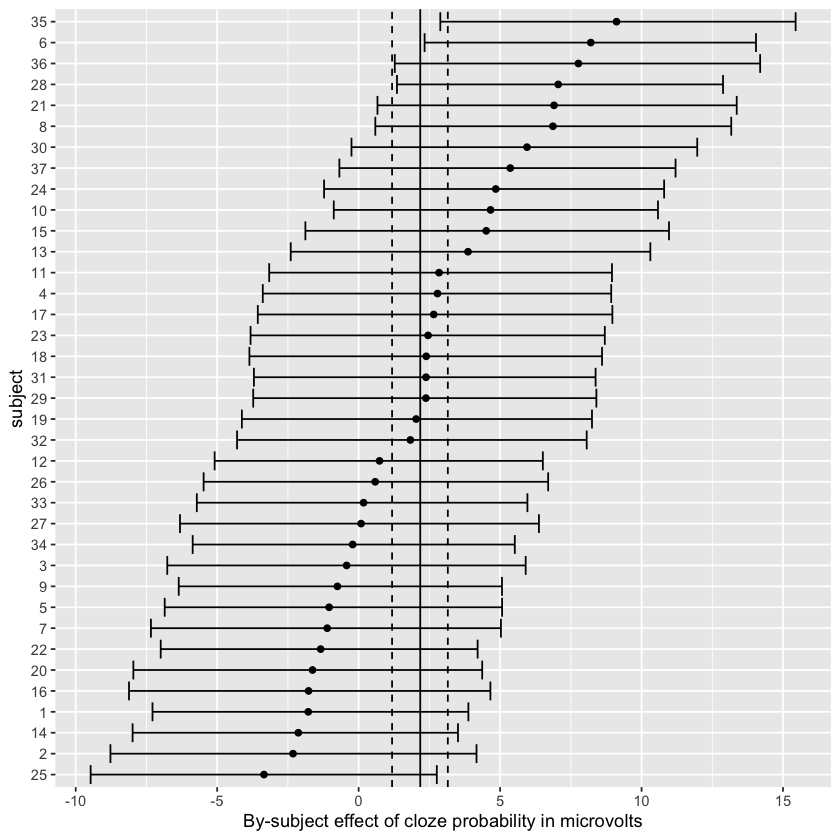

In [104]:
ggplot(
  beta_by_subj,
  aes(x = Estimate, xmin = Q2.5, xmax = Q97.5, y = subject)
) +
  geom_point() +
  geom_errorbarh() +
  geom_vline(xintercept = grand_av_beta$mean) +
  geom_vline(xintercept = grand_av_beta$lq, linetype = "dashed") +
  geom_vline(xintercept = grand_av_beta$hq, linetype = "dashed") +
  xlab("By-subject effect of cloze probability in microvolts")

### Varying intercepts and varying slopes model

One major problem with the no-pooling model is that we completely ignore the fact that the subjects were doing the same experiment. We fit each subject’s data ignoring the information available in the other subjects’ data. The no-pooling model is very likely to overfit the individual subjects’ data; we are likely to ignore the generalities of the data and we may end up overinterpreting noisy estimates from each subject’s data.

In the model that we fit next, we will assume that there is an overall effect that is common to the subjects and, importantly, that all subjects’ parameters originate from one common (normal) distribution. This model specification will result in the estimation of posteriors for each subject being also influenced by what we know about all the subjects together. We begin with a hierarchical model with uncorrelated varying intercepts and slopes.

Model assumptions:
1. EEG averages for the N400 spatio-temporal window are normally distributed.
2. Each subject deviates to some extent (this is made precise below) from the grand mean and from the mean effect of predictability. This implies that there is some between-subject variability in the individual-level intercept and slope adjustments by subject.
3. There is a linear relationship between cloze and the EEG signal.

#### Priors

**The likelihood now incorporates the assumption that both the intercept and slope are adjusted by subject:**

\begin{equation}
  signal_n \sim \mathit{Normal}(\alpha + u_{subj[n],1} + c\_cloze_n \cdot (\beta+ u_{subj[n],2}),\sigma)
 \end{equation}
 
 

\begin{equation}
 \begin{aligned}
 \alpha &\sim \mathit{Normal}(0,10)\\
 \beta  &\sim \mathit{Normal}(0,10)\\
 u_1 &\sim \mathit{Normal}(0,\tau_{u_1})\\
 u_2 &\sim \mathit{Normal}(0,\tau_{u_2})\\
 \tau_{u_1} &\sim \mathit{Normal}_+(0,20) \\
 \tau_{u_2} &\sim \mathit{Normal}_+(0,20) \\
 \sigma  &\sim \mathit{Normal}_+(0,50)
 \end{aligned}
 \end{equation}

So - we adjust main mean for each subject separately ($u_1$) and slope (beta) again for each subject separately ($u_2$). Both 'adjustments' have to have their own SD - tau. The standard deviations of these two adjustment terms, represent in fact between subject variability.

The variance components $τ_{u1}$ and  $τ_{u1}$ characterize **between-subject variability**, and the variance component $σ$ characterizes **within-subject variability**.

We know that in general, in EEG experiments, the standard deviations for the by-subject adjustments are smaller than the standard deviation of the observations (which is the within-subjects standard deviation). That is, usually the between-subject variability in the intercepts and slopes is smaller than the within-subjects variability in the data. For this reason, reducing the scale of the truncated normal distribution to 20 (in comparison to 50) seems reasonable for the priors of the τ parameters.

#### Model

In [101]:
prior_v <-
  c(
    prior(normal(0, 10), class = Intercept),
    prior(normal(0, 10), class = b, coef = c_cloze),
    prior(normal(0, 50), class = sigma),
    prior(normal(0, 20), class = sd, coef = Intercept, group = subj),
    prior(normal(0, 20), class = sd, coef = c_cloze, group = subj)
  )

In [102]:
fit_N400_v <- brm(n400 ~ c_cloze + (c_cloze || subj),
  prior = prior_v,
  data = df_eeg
)

Compiling Stan program...

Start sampling



In [85]:
fit_N400_v

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: n400 ~ c_cloze + (c_cloze || subj) 
   Data: df_eeg (Number of observations: 2863) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Group-Level Effects: 
~subj (Number of levels: 37) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     2.17      0.36     1.54     2.95 1.00     1781     2701
sd(c_cloze)       1.75      0.91     0.15     3.53 1.00     1081     1336

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     3.65      0.43     2.78     4.48 1.00     1429     1803
c_cloze       2.33      0.63     1.08     3.57 1.00     3821     2578

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma    11.62      0.16    11.32    11.93 1.00     7556     2961

Draws were sampled using sampling(NUTS). For each parameter, Bu

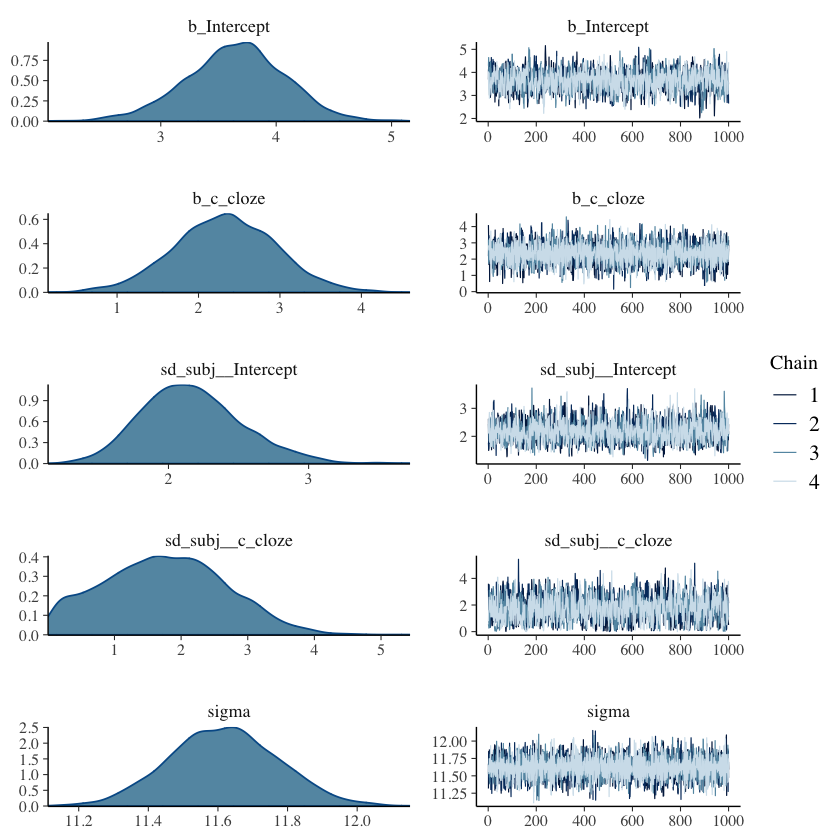

In [87]:
plot(fit_N400_v)

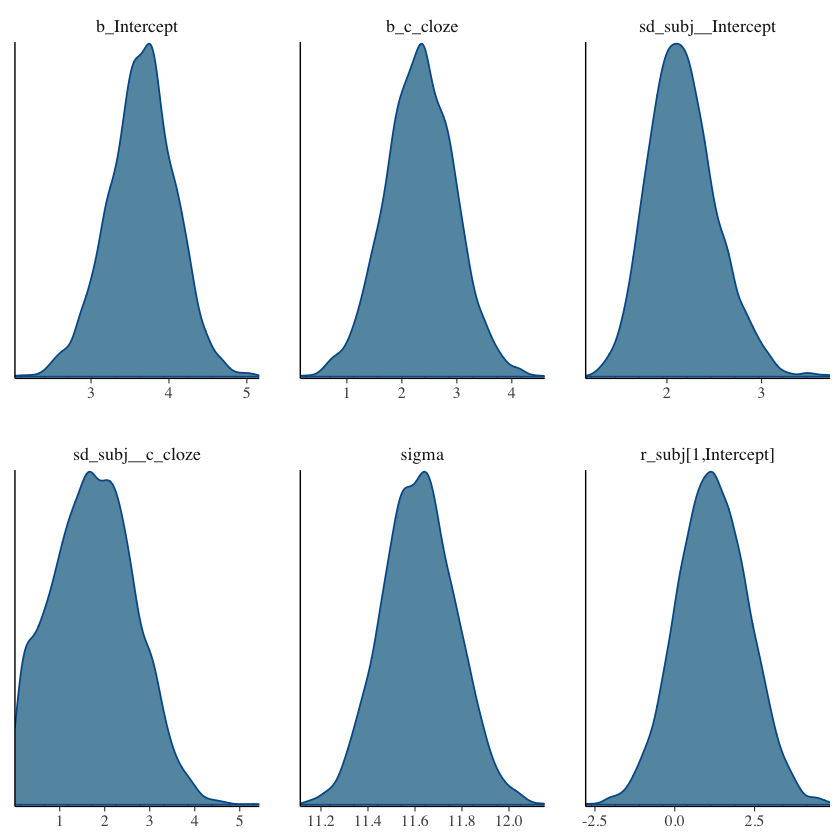

In [86]:
# plot results
mcmc_dens(fit_N400_v, pars = variables(fit_N400_v)[1:6])

In [89]:
head(as.data.frame(fit_N400_v))

b_Intercept b_c_cloze sd_subj__Intercept sd_subj__c_cloze sigma   
1 3.691237    4.0929162 2.625384           3.6009111        11.31740
2 4.127048    3.0498543 1.495143           1.8288698        11.85013
3 4.312812    1.6668993 1.664646           0.9617058        11.49029
4 4.133703    2.8839525 2.033711           3.0484974        11.73934
5 4.265347    3.0867862 2.096226           1.5766755        11.87332
6 3.726078    0.6219778 1.958786           2.6330562        11.40918
  r_subj[1,Intercept] r_subj[2,Intercept] r_subj[3,Intercept]
1  2.59489688         -0.9033272          -1.2666176         
2  0.50880632         -0.1066419          -0.5348838         
3  1.01589055         -2.2247943          -1.4502774         
4  0.41794677         -0.3549047          -0.7446868         
5 -0.03938655         -2.4987649           0.6941181         
6  1.93999933         -0.3847457          -1.7479532         
  r_subj[4,Intercept] r_subj[5,Intercept] ⋯ r_subj[30,c_cloze]
1 2.0240461           -2.3508896          ⋯ 0.7435136         
2 3.5802465           -0.9464142          ⋯ 0.5471026         
3 0.2361979           -2.5757460          ⋯ 0.3964755         
4 4.4504394           -1.2039230          ⋯ 2.0444860         
5 2.9625379           -0.7000462          ⋯ 0.5090020         
6 1.4891663           -2.5651367          ⋯ 1.3275554         
  r_subj[31,c_cloze] r_subj[32,c_cloze] r_subj[33,c_cloze] r_subj[34,c_cloze]
1 -5.3738934         -0.8000006         -4.0729077         -1.9995608        
2  2.1334503         -0.7668715          0.2490662         -1.5410173        
3 -1.2277659          0.3147041         -0.4457346         -0.1810313        
4  3.8091793         -1.6173340         -0.7125167         -1.1422318        
5 -0.6016088         -0.3454935          0.7449081         -0.2633170        
6 -0.3857355         -0.7285567         -1.0599575         -0.6952266        
  r_subj[35,c_cloze] r_subj[36,c_cloze] r_subj[37,c_cloze] lprior    lp__     
1  7.697138921       -0.05960832         8.352231          -17.22624 -11193.89
2 -0.828057073        2.44664500        -2.684903          -17.19064 -11201.28
3  1.824288211       -0.37821842         2.060364          -17.16183 -11202.88
4 -0.006386244        5.06725838        -3.491517          -17.19528 -11191.28
5  1.344373739       -2.14531417        -1.178030          -17.19931 -11211.38
6  6.898333410        5.69663896         4.639032          -17.13476 -11198.68

In [93]:
# make a table of u_2s
ind_effects_v <- paste0("r_subj[", unique(df_eeg$subj), 
                        ",c_cloze]")
head(ind_effects_v)

[1] "r_subj[1,c_cloze]" "r_subj[2,c_cloze]" "r_subj[3,c_cloze]"
[4] "r_subj[4,c_cloze]" "r_subj[5,c_cloze]" "r_subj[6,c_cloze]"

In [107]:
# add column with subject number
u_2_v <- posterior_summary(fit_N400_v, variable = ind_effects_v) %>%
    as_tibble() %>%
    mutate(subject = 1:n()) %>%
    arrange(Estimate) %>% # order by means
    mutate(subject = factor(subject, levels = subject))


In [108]:
head(u_2_v)

Estimate   Est.Error Q2.5      Q97.5    subject
1 -1.4121723 1.843357  -5.775947 1.360677 25     
2 -1.2335895 1.724611  -5.214825 1.530983 14     
3 -1.0974952 1.754113  -5.171697 1.705523 1      
4 -1.0665826 1.782402  -5.331680 1.888826 2      
5 -0.9680596 1.667707  -4.751105 1.863127 22     
6 -0.9624061 1.703383  -4.958918 1.945416 20

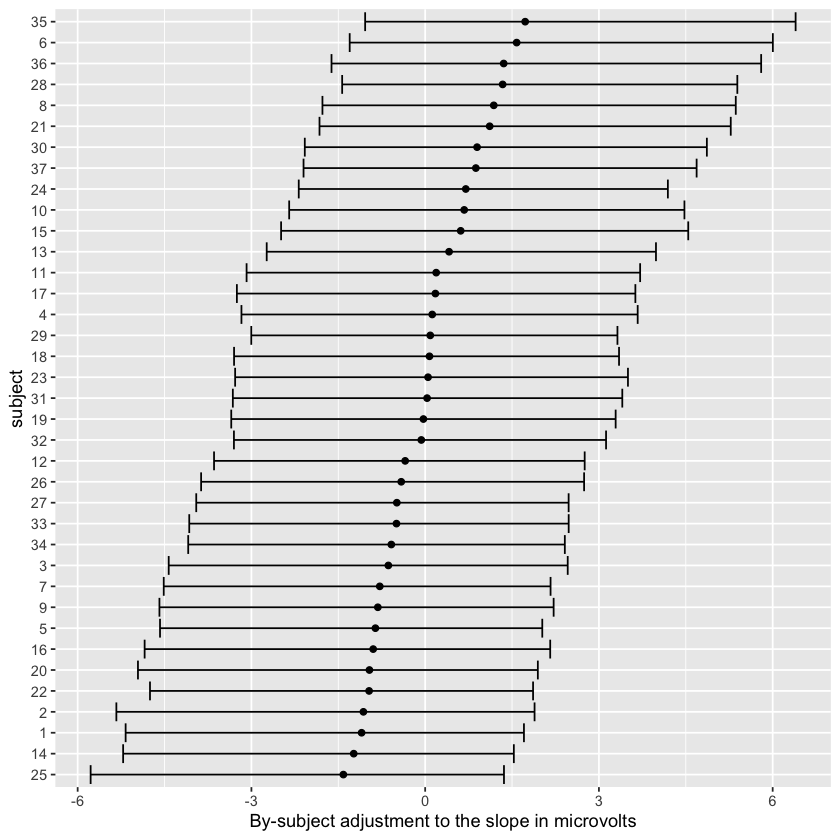

In [110]:
# plot results - plot of adjustments to the slope
ggplot(
  u_2_v,
  aes(x = Estimate, xmin = Q2.5, xmax = Q97.5, y = subject)
) +
  geom_point() +
  geom_errorbarh() +
  xlab("By-subject adjustment to the slope in microvolts")

In [105]:
# Extract the overall group level effect:
beta <- c(as_draws_df(fit_N400_v)$b_c_cloze)
# Extract the individual adjustments:
ind_effects_v <- paste0("r_subj[", unique(df_eeg$subj), ",c_cloze]")
adjustment <- as_draws_matrix(fit_N400_v, variable = ind_effects_v)
# Get the by subject effects in a data frame where each adjustment
# is in each column.
# Remove all the draws meta data by using as.data.frame
by_subj_effect <- as.data.frame(beta + adjustment)
# Summarize them by getting a table with the mean and the
# quantiles for each column and then binding them.
par_h <- lapply(by_subj_effect, function(x) {
  tibble(
    Estimate = mean(x),
    Q2.5 = quantile(x, .025),
    Q97.5 = quantile(x, .975)
  )
}) %>%
  bind_rows() %>%
  # Add a column to identify that the model,
  # and one with the subject labels:
  mutate(
    model = "Hierarchical",
    subj = unique(df_eeg$subj)
  ) %>%
  arrange(Estimate) %>%
  mutate(subj = factor(subj, levels = unique(.data$subj)))

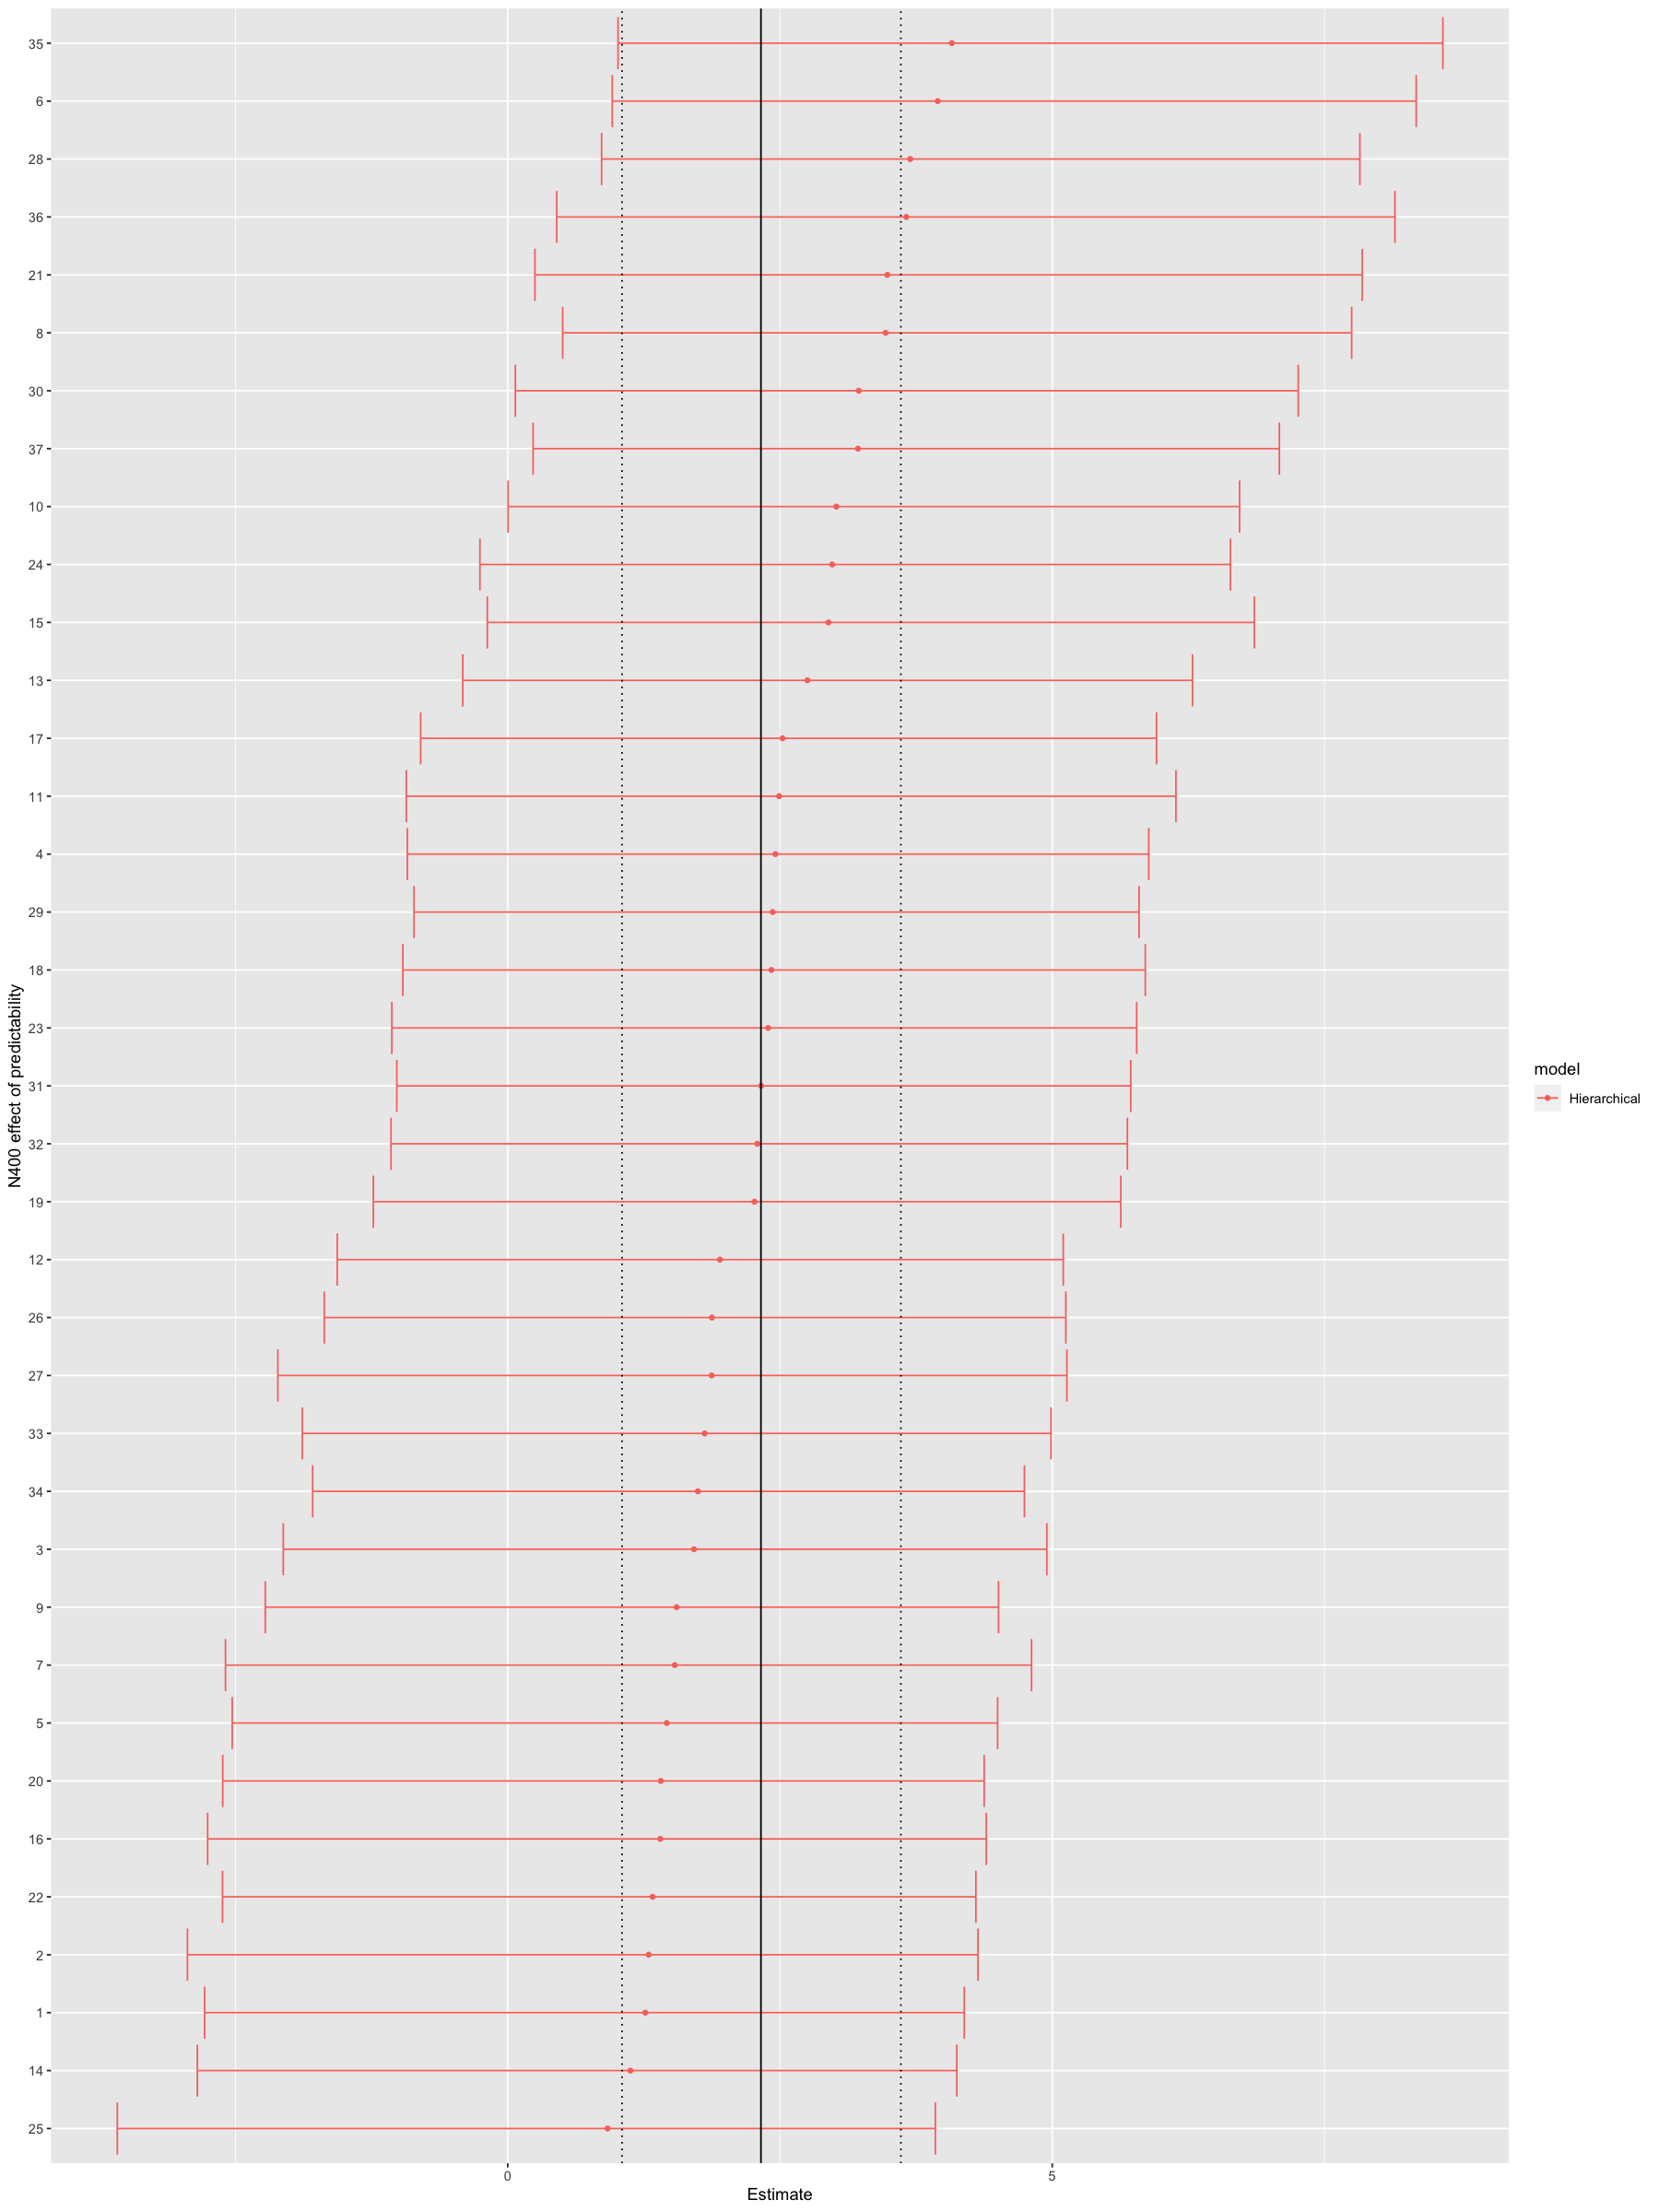

In [106]:
ggplot(
  par_h,
  aes(
    ymin = Q2.5, ymax = Q97.5, x = subj, y = Estimate, color = model,
    shape = model
  )
) +
  geom_errorbar(position = position_dodge(1)) +
  geom_point(position = position_dodge(1)) +
  # We'll also add the mean and 95% CrI of the overall difference
  # to the plot:
  geom_hline(
    yintercept =
      posterior_summary(fit_N400_v,
                        variable = "b_c_cloze")[, "Estimate"]
  ) +
  geom_hline(
    yintercept =
      posterior_summary(fit_N400_v,
                        variable = "b_c_cloze")[, "Q2.5"],
    linetype = "dotted", size = .5
  ) +
  geom_hline(
    yintercept =
      posterior_summary(fit_N400_v,
                        variable = "b_c_cloze")[, "Q97.5"],
    linetype = "dotted", size = .5
  ) +
  xlab("N400 effect of predictability") +
  coord_flip()

### Correlated varying intercept varying slopes model

In $M_h$, we model the EEG data with the following assumptions:

1. EEG averages for the N400 spatio-temporal window are normally distributed.
2. Some aspects of the mean signal voltage and of the effect of predictability depend on the subject, and these two might be correlated, i.e., we assume group-level intercepts and slopes, and allow a correlation between them by-subject.
3. There is a linear relationship between cloze and the EEG signal for the trial.

\begin{equation}
  signal_n \sim \mathit{Normal}(\alpha + u_{subj[n],1} + c\_cloze_n \cdot  (\beta + u_{subj[n],2}),\sigma)
  \end{equation}

#### Priors

$$
\begin{equation}
 \begin{aligned}
 \alpha & \sim \mathit{Normal}(0,10)\\
 \beta  & \sim \mathit{Normal}(0,10)\\
  \sigma  &\sim \mathit{Normal}_+(0,50)\\
  {\begin{pmatrix}
  u_{i,1} \\
  u_{i,2}
  \end{pmatrix}}
 &\sim {\mathcal {N}}
  \left(
 {\begin{pmatrix} 
  0\\
  0 
 \end{pmatrix}}
 \boldsymbol{\Sigma_u} \right)
 \end{aligned}
 \end{equation}
 $$

In this example, the covariance between two variables $u_1$ and $u_2$ is defined as the product of their correlation $ρ$ and their standard deviations $τ_{u1}$ and $τ_{u2}$:
 
$$
\begin{equation}
\boldsymbol{\Sigma_u} = 
{\begin{pmatrix} 
\tau_{u_1}^2 & \rho_u \tau_{u_1} \tau_{u_2} \\ 
\rho_u \tau_{u_1} \tau_{u_2} & \tau_{u_2}^2 
\end{pmatrix}} 
\end{equation}
$$

#### Model

In [9]:
prior_h <- c(
  prior(normal(0, 10), class = Intercept),
  prior(normal(0, 10), class = b, coef = c_cloze),
  prior(normal(0, 50), class = sigma),
  prior(normal(0, 20),class = sd, coef = Intercept,group = subj),
  prior(normal(0, 20),class = sd, coef = c_cloze,group = subj),
  prior(lkj(2), class = cor, group = subj)
)

In [112]:
fit_N400_h <- brm(n400 ~ c_cloze + (c_cloze | subj),
  prior = prior_h,
  data = df_eeg
)

ERROR: Error in .validate_prior(prior, bterms = bterms, data = data, sample_prior = sample_prior): nie znaleziono obiektu 'prior_h'


In [11]:
fit_N400_h

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: n400 ~ c_cloze + (c_cloze | subj) 
   Data: df_eeg (Number of observations: 2863) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Group-Level Effects: 
~subj (Number of levels: 37) 
                       Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)              2.19      0.37     1.56     2.97 1.00     1511
sd(c_cloze)                1.55      0.91     0.10     3.37 1.00     1053
cor(Intercept,c_cloze)     0.16      0.36    -0.61     0.81 1.00     3215
                       Tail_ESS
sd(Intercept)              2301
sd(c_cloze)                1712
cor(Intercept,c_cloze)     2525

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     3.65      0.43     2.83     4.52 1.00     1312     2014
c_cloze       2.33      0.60     1.15     3.51 1.00     3778     2784

Family Specific Paramete

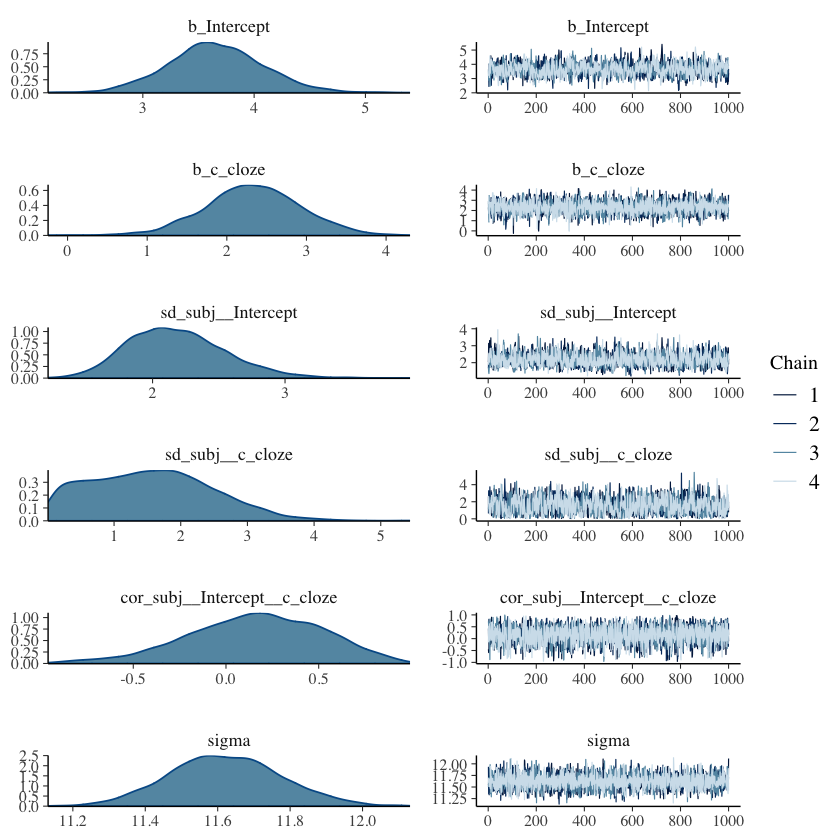

In [12]:
plot(fit_N400_h, N=6)

### By-subjects and by-items correlated varying intercept varying slopes model

In $M_{sih}$, we model the EEG data with the following assumptions:
1. EEG averages for the N400 spatio-temporal window are normally distributed.
2. Some aspects of the mean signal voltage and of the effect of predictability depend on the subject, i.e., we assume group-level intercepts, and slopes, and a correlation between them by-subject.
3. Some aspects of the mean signal voltage and of the effect of predictability depend on the item, i.e., we assume group-level intercepts, and slopes, and a correlation between them by-item.
4. There is a linear relationship between cloze and the EEG signal for the trial.

$$
\begin{equation}
  signal_n \sim \mathit{Normal}(\alpha + u_{subj[n],1} + w_{item[n],1} + c\_cloze_n \cdot  (\beta + u_{subj[n],2}+ w_{item[n],2}), \sigma)
\end{equation}
$$

#### Priors

$$
\begin{equation}
 \begin{aligned}
 \alpha & \sim \mathit{Normal}(0,10) \\
 \beta  & \sim \mathit{Normal}(0,10) \\
  \sigma  &\sim \mathit{Normal}_+(0,50)\\
  {\begin{pmatrix}
  u_{i,1} \\
  u_{i,2}
  \end{pmatrix}}
 &\sim {\mathcal {N}}
  \left(
 {\begin{pmatrix} 
  0\\
  0
 \end{pmatrix}}
 ,\boldsymbol{\Sigma_u} \right) \\
   {\begin{pmatrix}
  w_{j,1} \\
  w_{j,2}
  \end{pmatrix}}
 &\sim {\mathcal {N}}
  \left(
 {\begin{pmatrix} 
  0\\
  0
 \end{pmatrix}}
 ,\boldsymbol{\Sigma_w} \right) 
 \end{aligned}
 \end{equation}
 $$

and translating to model's parameters (hyperparameters):
$$
\begin{equation}
\begin{aligned}
 \boldsymbol{\Sigma_u} & = 
{\begin{pmatrix} 
\tau_{u_1}^2 & \rho_u \tau_{u_1} \tau_{u_2} \\ 
\rho_u \tau_{u_1} \tau_{u_2} & \tau_{u_2}^2
\end{pmatrix}}\\
 \boldsymbol{\Sigma_w} & = 
{\begin{pmatrix} 
\tau_{w_1}^2 & \rho_w \tau_{w_1} \tau_{w_2} \\ 
\rho_w \tau_{w_1} \tau_{w_2} & \tau_{w_2}^2
\end{pmatrix}}
 \end{aligned}
\end{equation}

\begin{equation}
\begin{aligned}
\tau_{u_1} &\sim \mathit{Normal}_+(0,20)\\
\tau_{u_2} &\sim \mathit{Normal}_+(0,20)\\
\rho_u &\sim \mathit{LKJcorr}(2) \\
\tau_{w_1} &\sim \mathit{Normal}_+(0,20)\\
\tau_{w_2} &\sim \mathit{Normal}_+(0,20)\\
\rho_w &\sim \mathit{LKJcorr}(2) \\
\end{aligned}
\end{equation}
$$

#### Model

In [13]:
prior_sih_full <-
  c(
    prior(normal(0, 10), class = Intercept),
    prior(normal(0, 10), class = b, coef = c_cloze),
    prior(normal(0, 50), class = sigma),
    prior(normal(0, 20),class = sd, coef = Intercept,group = subj),
    prior(normal(0, 20),class = sd, coef = c_cloze,group = subj),
    prior(lkj(2), class = cor, group = subj),
    prior(normal(0, 20),class = sd, coef = Intercept, group = item),
    prior(normal(0, 20),class = sd, coef = c_cloze, group = item),
    prior(lkj(2), class = cor, group = item))

In [14]:
fit_N400_sih <- brm(n400 ~ c_cloze + (c_cloze | subj) +
  (c_cloze | item),
prior = prior_sih_full,
data = df_eeg
)

Compiling Stan program...

Start sampling



In [15]:
fit_N400_sih

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: n400 ~ c_cloze + (c_cloze | subj) + (c_cloze | item) 
   Data: df_eeg (Number of observations: 2863) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Group-Level Effects: 
~item (Number of levels: 80) 
                       Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)              1.52      0.35     0.84     2.20 1.00     1622
sd(c_cloze)                2.25      1.02     0.26     4.26 1.00     1049
cor(Intercept,c_cloze)    -0.42      0.32    -0.91     0.33 1.00     2484
                       Tail_ESS
sd(Intercept)              2412
sd(c_cloze)                1310
cor(Intercept,c_cloze)     2495

~subj (Number of levels: 37) 
                       Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)              2.19      0.37     1.56     2.97 1.00     1800
sd(c_cloze)                1.46      0.91     0.08     3.42 1.00 

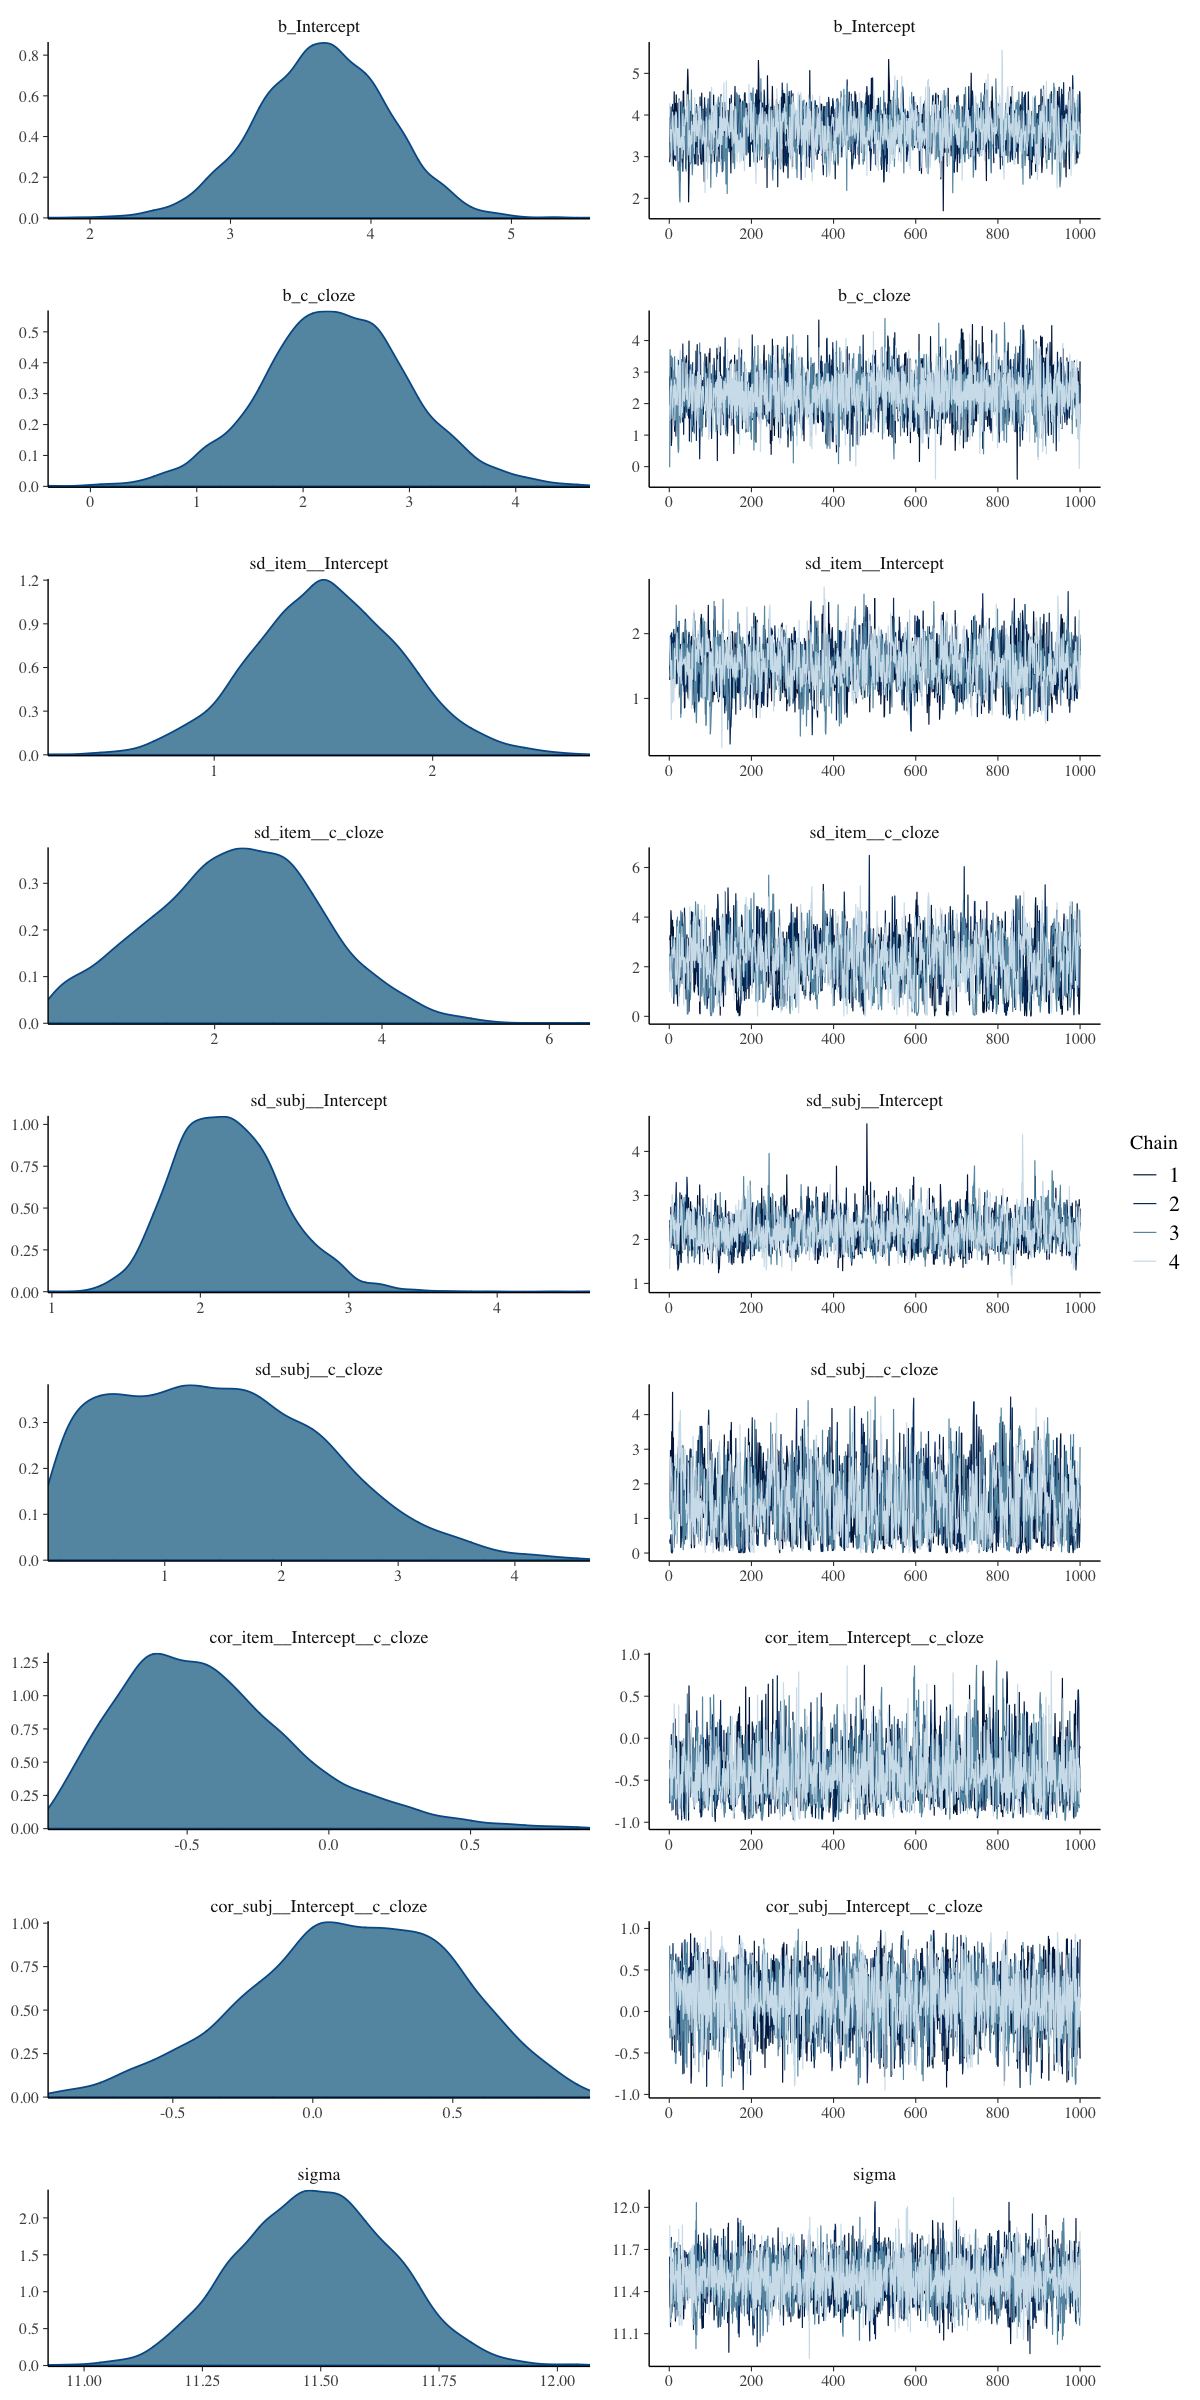

In [21]:
options(repr.plot.width = 10, repr.plot.height = 20)
plot(fit_N400_sih, N=9)

#### Posterior predictive checks

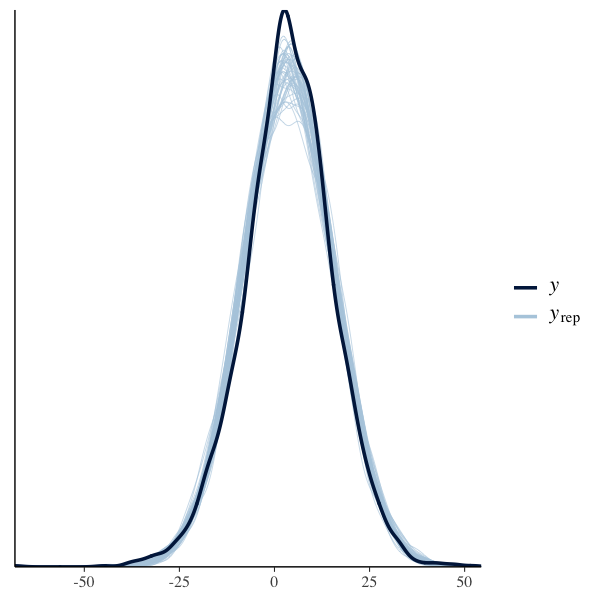

In [22]:
options(repr.plot.width = 5, repr.plot.height = 3)
pp_check(fit_N400_sih, ndraws = 50, type = "dens_overlay") 

Predictive checks per subject

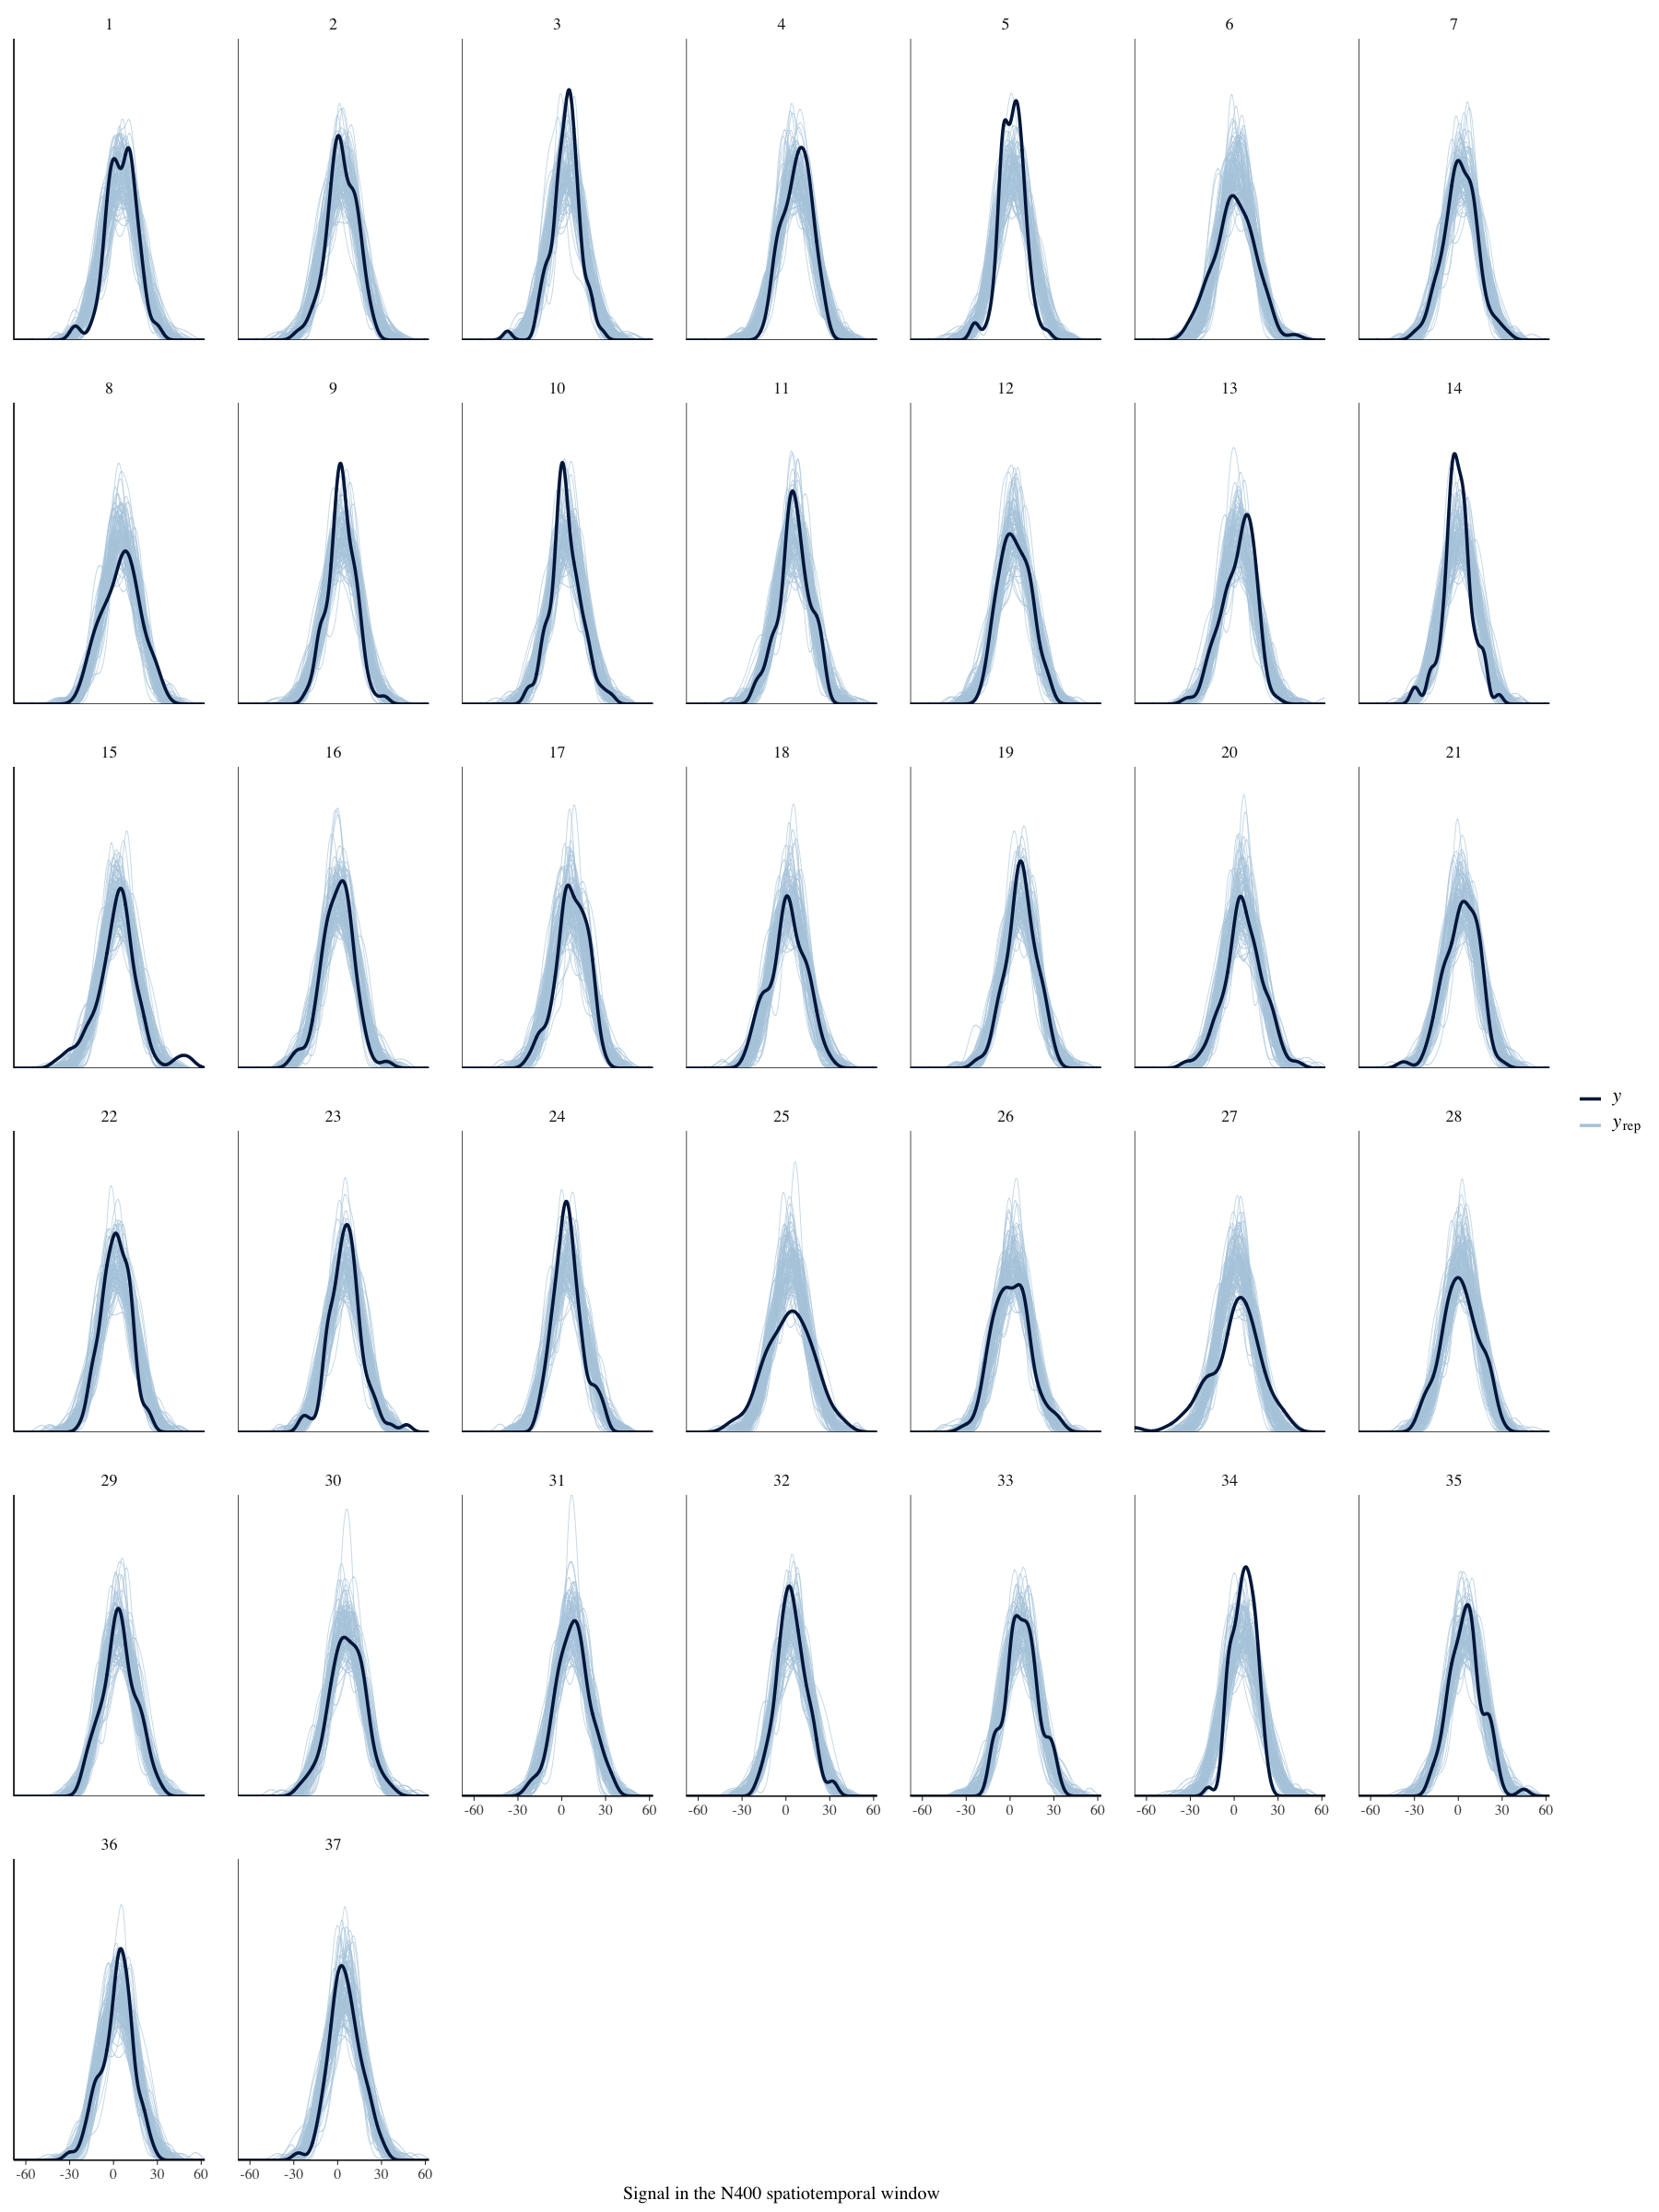

In [25]:
options(repr.plot.width = 15, repr.plot.height = 20)

ppc_dens_overlay_grouped(df_eeg$n400,
  yrep =
    posterior_predict(fit_N400_sih,
      ndraws = 100
    ),
  group = df_eeg$subj
) +
  xlab("Signal in the N400 spatiotemporal window")

Another approach to examine whether we misfit the by-subject noise level is to plot posterior distributions of the standard deviations and compare them with the observed standard deviation. This is achieved in the following code, which groups the data by subject, and shows the distribution of standard deviations. The result is shown in the figure below:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



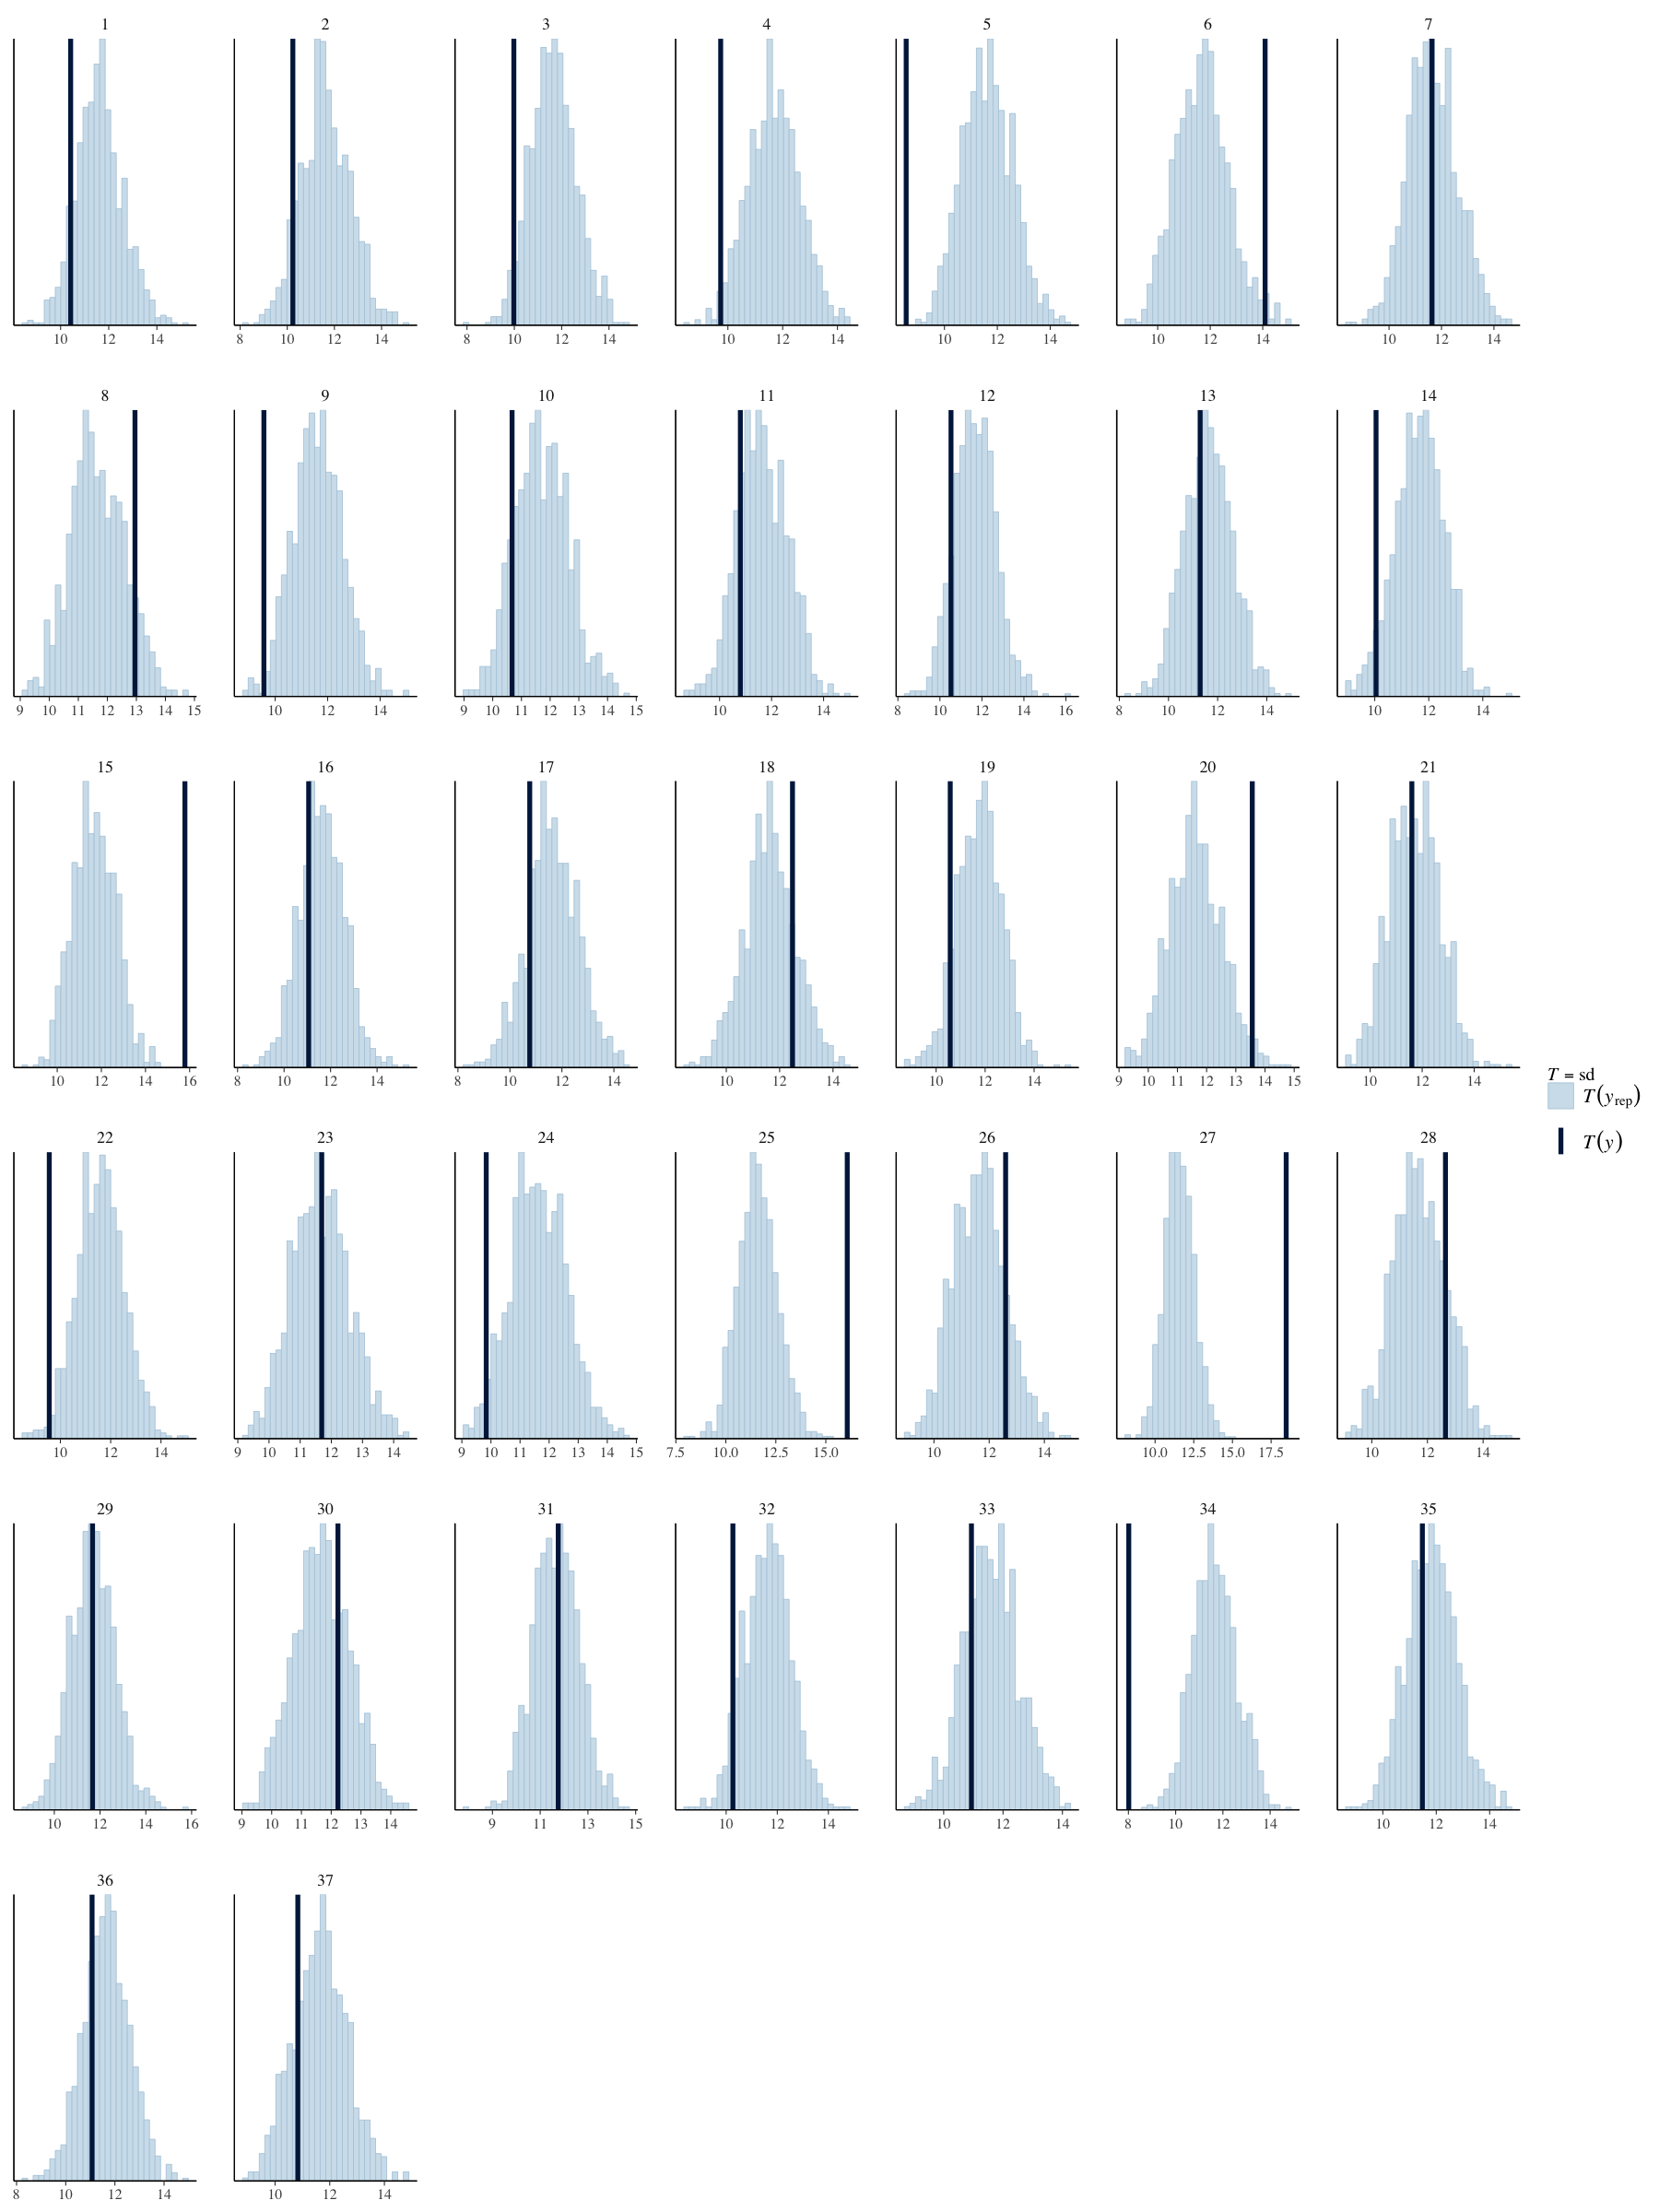

In [26]:
pp_check(fit_N400_sih,
  type = "stat_grouped",
  ndraws = 1000,
  group = "subj",
  stat = "sd"
)

### Varying sigmas to better model by-subject standard deviation (within-subject noise)

\begin{equation}
\begin{aligned}
  signal_n &\sim \mathit{Normal}(\alpha + u_{subj[n],1} + w_{item[n],1} + \\             &  \hspace{2cm} c\_cloze_n \cdot  (\beta + u_{subj[n],2}+ w_{item[n],2}), \sigma_n)\\
  \sigma_n &= \exp(\sigma_\alpha + \sigma_{u_{subj[n]}})
\end{aligned}
\end{equation}

\begin{equation}
\begin{aligned}
  \sigma_\alpha &\sim \mathit{Normal}(0,log(50))\\
  \sigma_u &\sim \mathit{Normal}(0, \tau_{\sigma_u}) \\
  \tau_{\sigma_u} &\sim \mathit{Normal}_+(0, 5)
\end{aligned}
\end{equation}

This model can be fit in brms using the internal function brmsformula(). This is a powerful function that extends the formulas that we used so far allowing for setting a hierarchical regression to any parameter of a model. This will allow us to set a by-subject hierarchical structure to the parameter $σ$. We also need to set new priors; these priors are identified by dpar = sigma

In [27]:
prior_s <- c(
  prior(normal(0, 10), class = Intercept),
  prior(normal(0, 10), class = b),
  prior(normal(0, 20), class = sd),
  prior(lkj(2), class = cor),
  prior(normal(0, log(50)), class = Intercept, dpar = sigma),
  prior(normal(0, 5),
    class = sd, group = subj,
    dpar = sigma
  )
)

In [28]:
fit_N400_s <- brm(brmsformula(
  n400 ~ c_cloze + (c_cloze | subj) + (c_cloze | item),
  sigma ~ 1 + (1 | subj)
),
prior = prior_s,
data = df_eeg
)

Compiling Stan program...

Start sampling



In [29]:
fit_N400_s

 Family: gaussian 
  Links: mu = identity; sigma = log 
Formula: n400 ~ c_cloze + (c_cloze | subj) + (c_cloze | item) 
         sigma ~ 1 + (1 | subj)
   Data: df_eeg (Number of observations: 2863) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Group-Level Effects: 
~item (Number of levels: 80) 
                       Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)              1.80      0.32     1.18     2.48 1.00     1571
sd(c_cloze)                1.77      1.00     0.12     3.79 1.00     1006
cor(Intercept,c_cloze)    -0.31      0.35    -0.87     0.52 1.00     2931
                       Tail_ESS
sd(Intercept)              2494
sd(c_cloze)                1893
cor(Intercept,c_cloze)     2600

~subj (Number of levels: 37) 
                       Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)              2.23      0.37     1.58     2.99 1.00     1751
sd(c_cloze)                1.52      0

In [40]:
options(repr.plot.width = 15, repr.plot.height = 20)

ppc_dens_overlay_grouped(df_eeg$n400,
  yrep =
    posterior_predict(fit_N400_s,
      ndraws = 100
    ),
  group = df_eeg$subj
) +
  xlab("Signal in the N400 spatiotemporal window")

ERROR: Error in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : polygon edge not found


plot without title

## A hierarchical log-normal model: The Stroop effect

### A correlated varying intercept varying slopes log-normal model

If our theory only focuses on the difference between the response times for the “congruent” vs. “incongruent” condition, we can ignore the actual color presented and the word that was written. For simplicity, we will also assume that all subjects share the same variance (as we saw in section 5.2.6, changing this assumption leads to distributional regression models).

\begin{equation}
  rt_n \sim \mathit{LogNormal}(\alpha + u_{subj[n],1} + c\_cond_n \cdot  (\beta + u_{subj[n],2}),\sigma)
  \end{equation}

With contrast coding:

$𝜇_{incongruent} = 𝛼 + 1 ⋅ 𝛽$

$𝜇_{congruent} = 𝛼 - 1 ⋅ 𝛽$

#### Priors

For the population-level parameters (or fixed effects), we use the same priors as we did when we were fitting a regression with a log-normal likelihood in section 3.6.3.

\begin{equation}
\begin{aligned}
\mu &\sim \mathit{Normal}(6, 1.5) \\
\beta &\sim \mathit{Normal}(0, 0.01) \\
\sigma &\sim \mathit{Normal}_+(0, 1) \\
\end{aligned}
\end{equation}

Here, 𝛽 represents,on the logscale,the change in the intercept 𝛼 as a function of the experimental manipulation.

In contrast to our previous models, the intercept 𝛼 is not the grand mean of the location. This is because the conditions were not balanced in the experiment (one-third of the conditions were congruent and two-thirds incongruent). The intercept could be interpreted here as the time (in logscale) it takes to respond if we ignore the experimental manipulation (we do not center the parameters, as they are binary and as trials are not balanced, the mean is not 0)

Next, we turn our attention to the prior specification for the group-level parameters (or random effects). If we assume a possible correlation between by-subject intercepts and slopes, our model will have the following structure.

We don’t expect the by-group adjustments to the intercept and slope to have more variance than the within-subject variance, so this prior will be quite conservative because it allows for a large range of prior uncertainty.

\begin{equation}
\begin{aligned}
\tau_{u_1} &\sim \mathit{Normal}_+(0,1)\\
\tau_{u_2} &\sim \mathit{Normal}_+(0,1)\\
\rho_u &\sim \mathit{LKJcorr}(2) \\
\end{aligned}
\end{equation}

In [4]:
data("df_stroop")

In [5]:
# contrast coding

df_stroop <- df_stroop %>% 
    mutate(c_cond = if_else(condition == "Incongruent", 1, -1))

In [36]:
head(df_stroop)

subj trial condition   RT   c_cond
1 1    0     Congruent   1484 -1    
2 1    1     Incongruent 1316  1    
3 1    2     Incongruent  628  1    
4 1    3     Congruent    511 -1    
5 1    4     Congruent    509 -1    
6 1    5     Incongruent  903  1

#### Model

In [6]:
fit_stroop <- brm(RT ~ c_cond + (c_cond | subj), 
                  family = lognormal(), 
                  prior =
                      c(
                          prior(normal(6, 1.5), class = Intercept), 
                          prior(normal(0, .1), class = b), 
                          prior(normal(0, 1), class = sigma), 
                          prior(normal(0, 1), class = sd), 
                          prior(lkj(2), class = cor) 
                      ), 
                  data = df_stroop
)

Compiling Stan program...

Start sampling



In [ ]:
fit_stroop

In [38]:
posterior_summary(fit_stroop, variable = "b_c_cond")

Estimate   Est.Error   Q2.5       Q97.5     
b_c_cond 0.02690597 0.005368884 0.01637758 0.03714731

If we overlay the density plots for the prior and posterior distributions of 𝛽 , it becomes evident that the prior might have been too restrictive: the posterior is relatively far from the prior, and the prior strongly down-weights the values that the posterior is centered around.

In [ ]:
# samples from posterior
sample_b_post <- as_draws_df(fit_stroop)$b_c_cond 

# We generate samples from the prior as well:
N <- length(sample_b_post) 
sample_b_prior <- rnorm(N, 0, .01) 
samples <- tibble(
    sample = c(sample_b_post, sample_b_prior),
    distribution = c(rep("posterior", N), rep("prior", N)) 
) 
options(repr.plot.width = 7, repr.plot.height = 5)
ggplot(samples, aes(x = sample, fill = distribution)) + geom_density(alpha = .5)

#### Sensitivity analysis

Here, the discrepancy evident in Figure 5.19 is investigated with a sensitivity analysis. We will examine what happens for the following priors for 𝛽 . In the models we fit below, all the other parameters have the same priors as in the model fit_stroop; we vary only the priors for 𝛽 . The different priors are:

- 𝛽 ∼ Normal(0, 0.05)

- 𝛽 ∼ Normal(0, 0.1)

- 𝛽 ∼ Normal(0, 1)

- 𝛽 ∼ Normal(0, 2)

In [41]:
# 0.05

fit_stroop_05 <- brm(RT ~ c_cond + (c_cond | subj), 
                  family = lognormal(), 
                  prior =
                      c(
                          prior(normal(6, 1.5), class = Intercept), 
                          prior(normal(0, .05), class = b), 
                          prior(normal(0, 1), class = sigma), 
                          prior(normal(0, 1), class = sd), 
                          prior(lkj(2), class = cor) 
                      ), 
                  data = df_stroop
)

# 0.01

fit_stroop_01 <- brm(RT ~ c_cond + (c_cond | subj), 
                  family = lognormal(), 
                  prior =
                      c(
                          prior(normal(6, 1.5), class = Intercept), 
                          prior(normal(0, .01), class = b), 
                          prior(normal(0, 1), class = sigma), 
                          prior(normal(0, 1), class = sd), 
                          prior(lkj(2), class = cor) 
                      ), 
                  data = df_stroop
)

# 1

fit_stroop_1 <- brm(RT ~ c_cond + (c_cond | subj), 
                  family = lognormal(), 
                  prior =
                      c(
                          prior(normal(6, 1.5), class = Intercept), 
                          prior(normal(0, 1), class = b), 
                          prior(normal(0, 1), class = sigma), 
                          prior(normal(0, 1), class = sd), 
                          prior(lkj(2), class = cor) 
                      ), 
                  data = df_stroop
)

# 2

fit_stroop_2 <- brm(RT ~ c_cond + (c_cond | subj), 
                  family = lognormal(), 
                  prior =
                      c(
                          prior(normal(6, 1.5), class = Intercept), 
                          prior(normal(0, 2), class = b), 
                          prior(normal(0, 1), class = sigma), 
                          prior(normal(0, 1), class = sd), 
                          prior(lkj(2), class = cor) 
                      ), 
                  data = df_stroop
)

Compiling Stan program...

Start sampling

Compiling Stan program...

Start sampling

Compiling Stan program...

Start sampling

Compiling Stan program...

Start sampling



In [54]:
models = list(fit_stroop_05, fit_stroop_01, fit_stroop_1, fit_stroop_2)

In [92]:
res = NULL
n = 1
for (model in models) {
    summary <- posterior_summary(model, variable = "b_c_cond") %>%    
    as_tibble() %>%
    mutate(model = n)
    
    res = bind_rows(res,summary)
    n = n + 1
    }

In [93]:
res

Estimate   Est.Error   Q2.5       Q97.5      model
1 0.03708677 0.006147314 0.02518806 0.04882647 1    
2 0.02676046 0.005534119 0.01583629 0.03783257 2    
3 0.03757235 0.006135072 0.02505687 0.04963629 3    
4 0.03747454 0.006244937 0.02505390 0.04951207 4

In [98]:
for (model in models) {
    alpha_samples <- as_draws_df(model)$b_Intercept 
    beta_samples <- as_draws_df(model)$b_c_cond

    median_effect_rt <- 
        exp(alpha_samples + beta_samples) - exp(alpha_samples - beta_samples)
    
    stats = c(mean_median_effect = mean(median_effect_rt),
    quantile(median_effect_rt, c(0.025, 0.975)))
                
    print(stats)
                
}

mean_median_effect               2.5%              97.5% 
          41.63286           28.09075           55.34242 
mean_median_effect               2.5%              97.5% 
          29.89748           17.52667           42.40842 
mean_median_effect               2.5%              97.5% 
          42.13935           27.92979           55.88675 
mean_median_effect               2.5%              97.5% 
          42.03762           28.21895           55.80150 


## Excercises

## 5.1

In [111]:
data("df_pupil_complete")
head(df_pupil_complete)

subj trial load p_size   
1 701  1     2    1021.4086
2 701  2     1     951.4349
3 701  3     5    1063.9569
4 701  4     4     913.4871
5 701  5     0     602.6868
6 701  6     3     826.2199

In [114]:
# centering data
df_pupil_complete <- df_pupil_complete %>%
  mutate(c_load = load - mean(load))

In [116]:
# maximal model

prior_pupil <- c(
  prior(normal(1000, 500), class = Intercept),
  prior(normal(0, 100), class = b, coef = c_load),
  prior(normal(0, 1000), class = sigma),
  prior(normal(0, 1000),class = sd, coef = Intercept,group = subj),
  prior(normal(0, 1000),class = sd, coef = c_load,group = subj),
  prior(lkj(2), class = cor, group = subj)
)

fit_pupil_full <- brm(p_size ~ c_load + (c_load | subj),
  prior = prior_pupil,
  data = df_pupil_complete
)


Compiling Stan program...

Start sampling



In [117]:
summary(fit_pupil_full)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: p_size ~ c_load + (c_load | subj) 
   Data: df_pupil_complete (Number of observations: 2228) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Group-Level Effects: 
~subj (Number of levels: 20) 
                      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)          3311.73    443.27  2513.21  4250.50 1.01      516
sd(c_load)               71.43     15.16    47.05   105.98 1.00     1178
cor(Intercept,c_load)     0.30      0.24    -0.22     0.70 1.00     1427
                      Tail_ESS
sd(Intercept)              976
sd(c_load)                1821
cor(Intercept,c_load)     2028

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept  2484.94    480.53  1534.97  3452.59 1.01      718      774
c_load       40.12     24.38    -8.45    87.62 1.00     1053     1842

Family Specific Param

In [119]:
posterior_summary(fit_pupil_full, variable = "b_c_load")
posterior_summary(fit_pupil_full, variable = "b_Intercept")

Estimate Est.Error Q2.5      Q97.5   
b_c_load 40.1209  24.38378  -8.447726 87.62167

Estimate Est.Error Q2.5     Q97.5   
b_Intercept 2484.937 480.527   1534.972 3452.589

#### Sensitivity analysis - influence of different mean priors on effect

In [120]:
# prior on mean 2000,1000

prior_pupil_2000 <- c(
  prior(normal(2000, 1000), class = Intercept),
  prior(normal(0, 100), class = b, coef = c_load),
  prior(normal(0, 1000), class = sigma),
  prior(normal(0, 1000),class = sd, coef = Intercept,group = subj),
  prior(normal(0, 1000),class = sd, coef = c_load,group = subj),
  prior(lkj(2), class = cor, group = subj)
)

fit_pupil_full_2000 <- brm(p_size ~ c_load + (c_load | subj),
  prior = prior_pupil_2000,
  data = df_pupil_complete
)

# prior on mean 4000,2000

prior_pupil_4000 <- c(
  prior(normal(4000, 2000), class = Intercept),
  prior(normal(0, 100), class = b, coef = c_load),
  prior(normal(0, 1000), class = sigma),
  prior(normal(0, 1000),class = sd, coef = Intercept,group = subj),
  prior(normal(0, 1000),class = sd, coef = c_load,group = subj),
  prior(lkj(2), class = cor, group = subj)
)

fit_pupil_full_4000 <- brm(p_size ~ c_load + (c_load | subj),
  prior = prior_pupil_4000,
  data = df_pupil_complete
)

Compiling Stan program...

Start sampling

Compiling Stan program...

Start sampling



In [123]:
models = list(fit_pupil_full, fit_pupil_full_2000, fit_pupil_full_4000)

In [124]:
res = NULL
n = 1
for (model in models) {
    summary <- posterior_summary(model, variable = "b_c_load") %>%    
    as_tibble() %>%
    mutate(model = n)
    
    res = bind_rows(res,summary)
    n = n + 1
    }
res

Estimate Est.Error Q2.5      Q97.5    model
1 40.12090 24.38378  -8.447726 87.62167 1    
2 54.52949 17.20282  19.598639 86.54825 2    
3 59.17284 15.95742  27.864424 90.60003 3

#### Effect by-subject

In [125]:
# Extract the overall group level effect:
beta <- c(as_draws_df(fit_pupil_full)$b_c_load)
# Extract the individual adjustments:
ind_effects_v <- paste0("r_subj[", unique(df_pupil_complete$subj), ",c_load]")
adjustment <- as_draws_matrix(fit_pupil_full, variable = ind_effects_v)
# Get the by subject effects in a data frame where each adjustment
# is in each column.
# Remove all the draws meta data by using as.data.frame
by_subj_effect <- as.data.frame(beta + adjustment)
# Summarize them by getting a table with the mean and the
# quantiles for each column and then binding them.
par_h <- lapply(by_subj_effect, function(x) {
  tibble(
    Estimate = mean(x),
    Q2.5 = quantile(x, .025),
    Q97.5 = quantile(x, .975)
  )
}) %>%
  bind_rows() %>%
  # Add a column to identify that the model,
  # and one with the subject labels:
  mutate(
    model = "Hierarchical",
    subj = unique(df_pupil_complete$subj)
  ) %>%
  arrange(Estimate) %>%
  mutate(subj = factor(subj, levels = unique(.data$subj)))

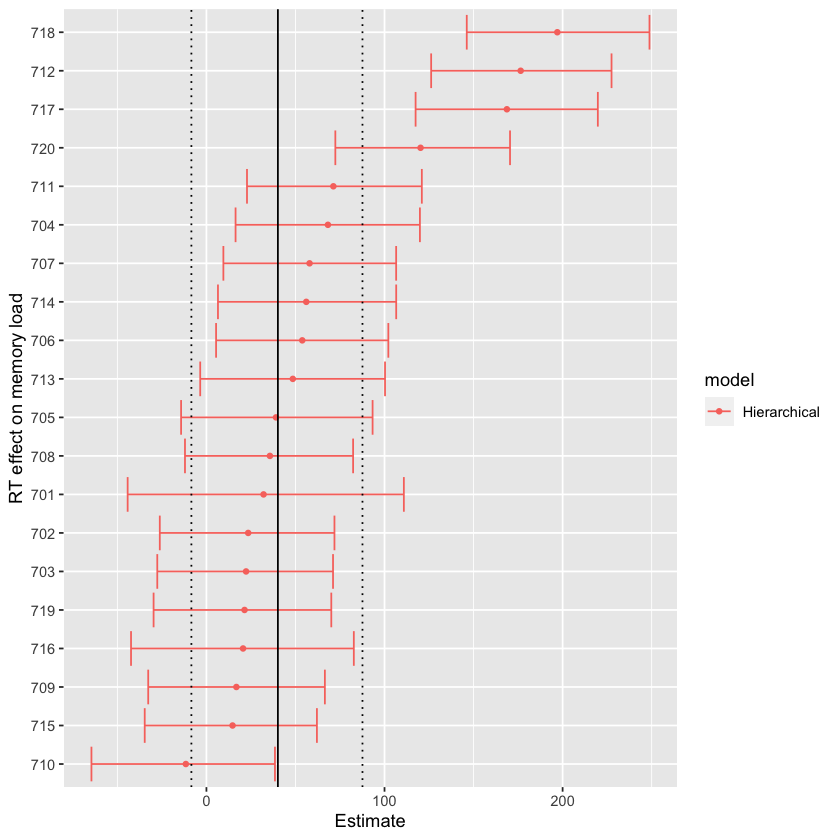

In [126]:
ggplot(
  par_h,
  aes(
    ymin = Q2.5, ymax = Q97.5, x = subj, y = Estimate, color = model,
    shape = model
  )
) +
  geom_errorbar(position = position_dodge(1)) +
  geom_point(position = position_dodge(1)) +
  # We'll also add the mean and 95% CrI of the overall difference
  # to the plot:
  geom_hline(
    yintercept =
      posterior_summary(fit_pupil_full,
                        variable = "b_c_load")[, "Estimate"]
  ) +
  geom_hline(
    yintercept =
      posterior_summary(fit_pupil_full,
                        variable = "b_c_load")[, "Q2.5"],
    linetype = "dotted", size = .5
  ) +
  geom_hline(
    yintercept =
      posterior_summary(fit_pupil_full,
                        variable = "b_c_load")[, "Q97.5"],
    linetype = "dotted", size = .5
  ) +
  xlab("RT effect on memory load") +
  coord_flip()

## 5.3

In [13]:
# load data
data("df_gibsonwu")
data("df_gibsonwu2")

In [14]:
head(df_gibsonwu)
head(df_gibsonwu2)

subj item type     rt  
94  1    13   obj-ext  1561
221 1     6   subj-ext  959
341 1     5   obj-ext   582
461 1     9   obj-ext   294
621 1    14   subj-ext  438
753 1     4   subj-ext  286

subj item condition pos rt   region   
9  1m1  15   obj-ext   8    832 head noun
20 1m1   8   subj-ext  8   2131 head noun
33 1m1  11   obj-ext   8    553 head noun
46 1m1  10   subj-ext  8   1091 head noun
62 1m1  16   subj-ext  8    598 head noun
75 1m1  14   subj-ext  8    645 head noun

In [39]:
# contrast coding

df_gibsonwu <- df_gibsonwu %>% 
    mutate(c_cond = if_else(type == "obj-ext", 0.5, -0.5))

df_gibsonwu2 <- df_gibsonwu2 %>% 
    mutate(c_cond = if_else(condition == "obj-ext", 0.5, -0.5))

For the first data set (df_gibsonwu), investigate this question by fitting two “maximal” hierarchical models (correlated varying intercept and slopes for subjects and items). The dependent variable in both models is the raw reading time in milliseconds. The first model should use the normal likelihood in the model; the second model should use the log-normal likelihood. In both models, use  
± 0.5 sum coding to model the effect of relative clause type. You will need to decide on appropriate priors for the various parameters.

[1] 548.4351

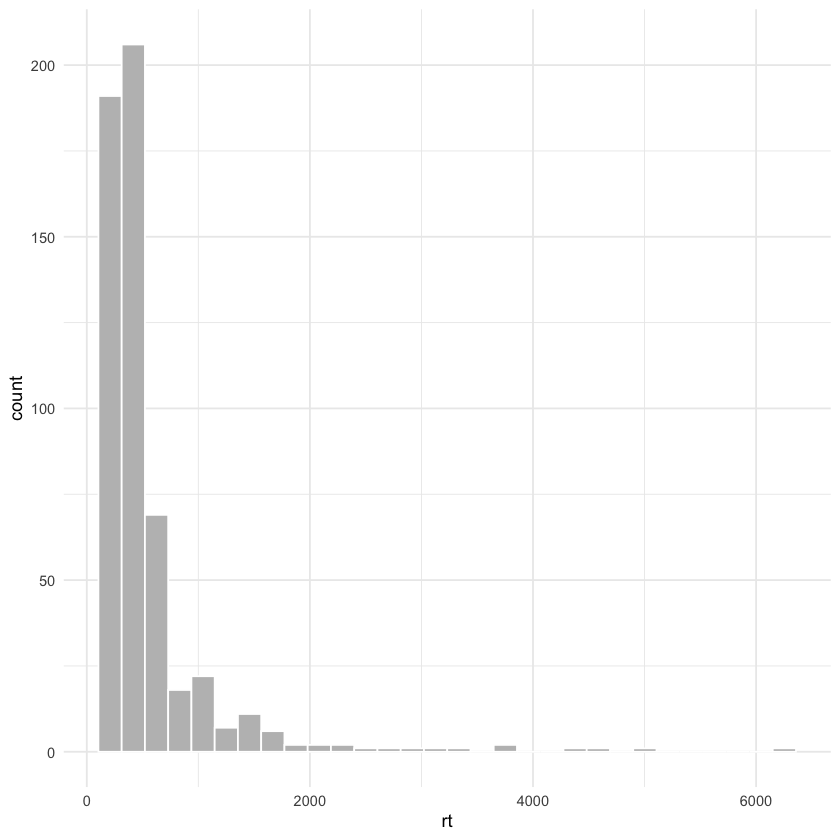

In [22]:
mean(df_gibsonwu$rt)
ggplot(df_gibsonwu, aes(x=rt)) + theme_minimal() + geom_histogram(bins=30, color="white", fill="grey")

In [36]:
# mean
qnorm(c(.025, .975), mean = 500, sd = 200)

# sigma - trunkated distribution
samples <- rtnorm(20000, mean = 0, sd = 1000, a = 0)
quantile(samples, probs = c(0.025, .975))

# beta
qnorm(c(.025, .975), mean = 0, sd = 500)


[1] 108.0072 891.9928

2.5%      97.5% 
  30.65808 2254.35702

[1] -979.982  979.982

In [41]:
# normal likelihood - full maximal model

priors_maximal_normal = c(
    prior(normal(500,200), class = Intercept),
    prior(normal(0,500), class = b, coef=c_cond),
    prior(normal(0,1000), class = sigma),
    prior(normal(0,500), class=sd),
    prior(lkj(2), class = cor)
)

In [42]:
fit_gbw_fullnormal <- brm(rt ~ c_cond + (1+ c_cond | subj) + (c_cond | item),
  family=gaussian(),
  prior = priors_maximal_normal,
  data = df_gibsonwu
)

Compiling Stan program...

Start sampling



In [81]:
samples <- rlnorm(2000, 6,0.5)
mean(samples)
sd(samples)

[1] 451.4919

[1] 230.3176

In [83]:
# log-normal likelihood - full maximal model

priors_maximal_log = c(
    prior(normal(6,0.6), class = Intercept),
    prior(normal(0,1), class = b, coef=c_cond),
    prior(normal(0,1), class = sigma),
    prior(normal(0,1), class=sd),
    prior(lkj(2), class = cor)
)

In [98]:
fit_gbw_fulllog <- brm(rt ~ c_cond + (1+ c_cond | subj) + (c_cond | item),
  family=lognormal(),
  prior = priors_maximal_log,
  data = df_gibsonwu
)

##### Compare posterior predictive distributions of normal and log-normal models

In [85]:
pp_gwnormal<-pp_check(fit_gbw_fullnormal,ndraws=1000) 
pp_gwlogn<-pp_check(fit_gbw_fulllog,ndraws=1000)

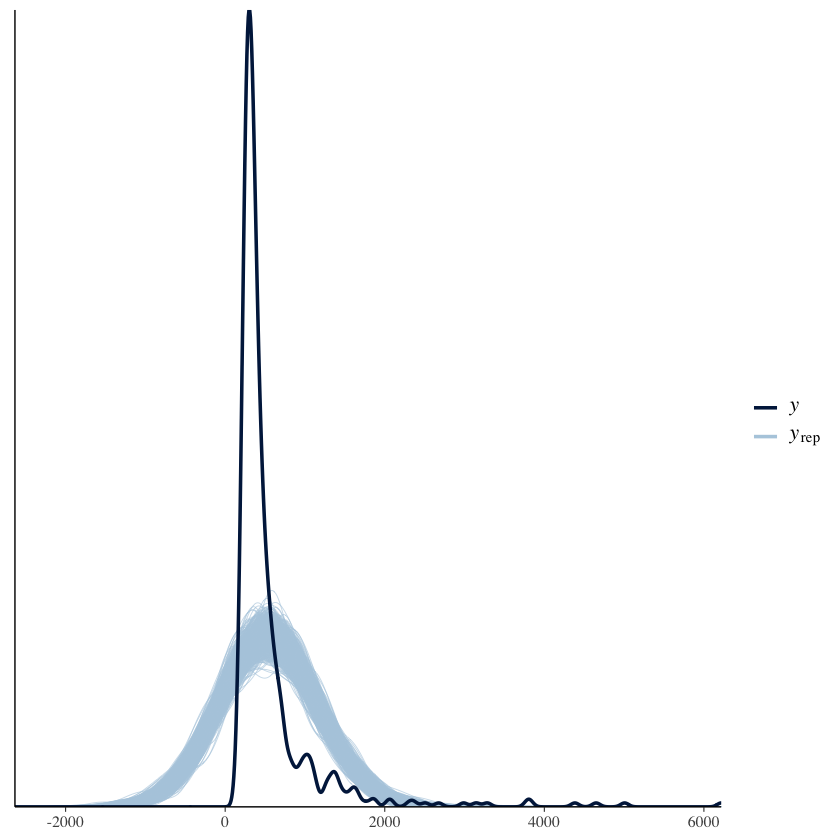

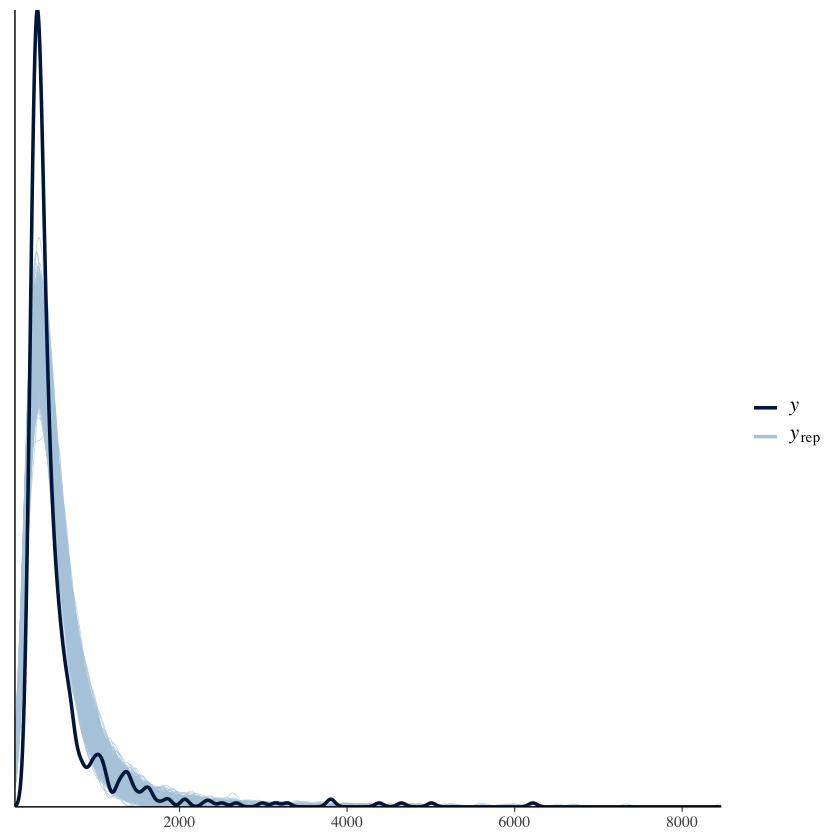

In [86]:
pp_gwnormal
pp_gwlogn

##### Effect in ms

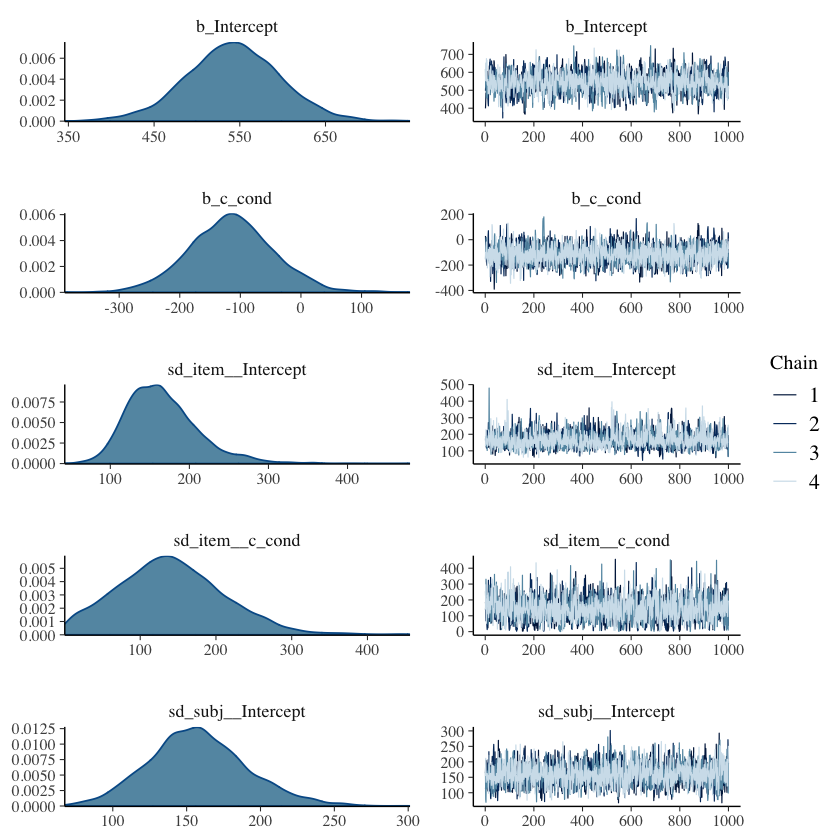

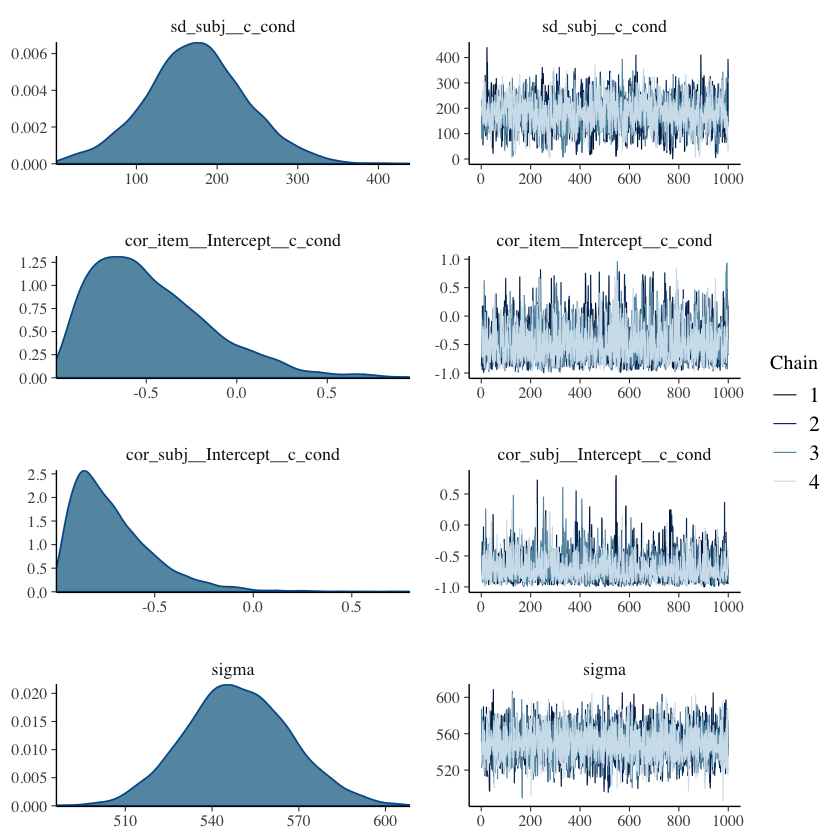

In [90]:
plot(fit_gbw_fullnormal)

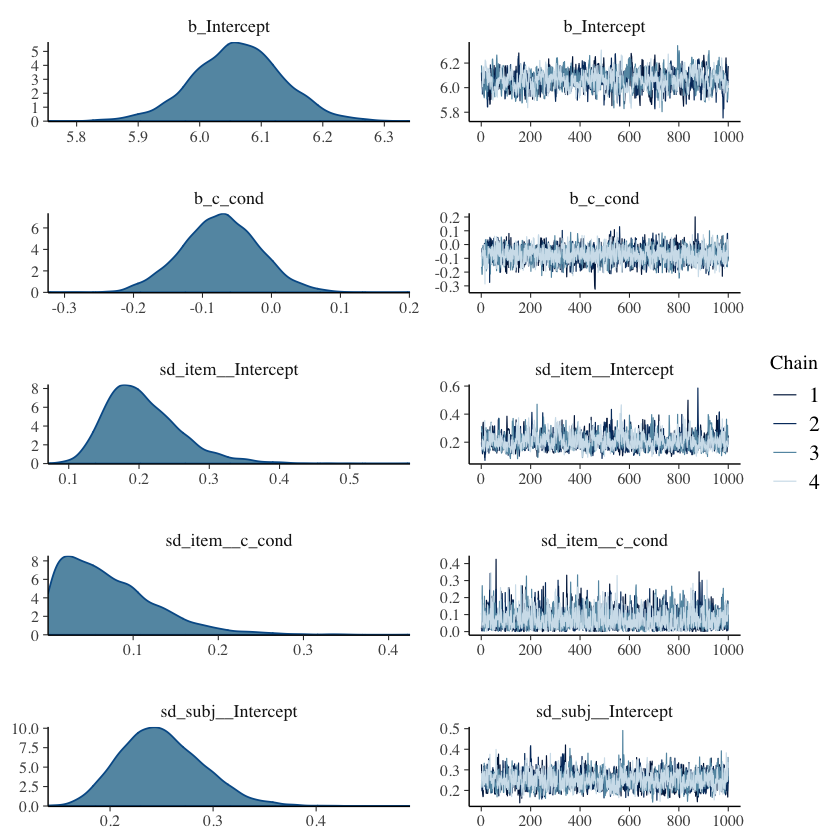

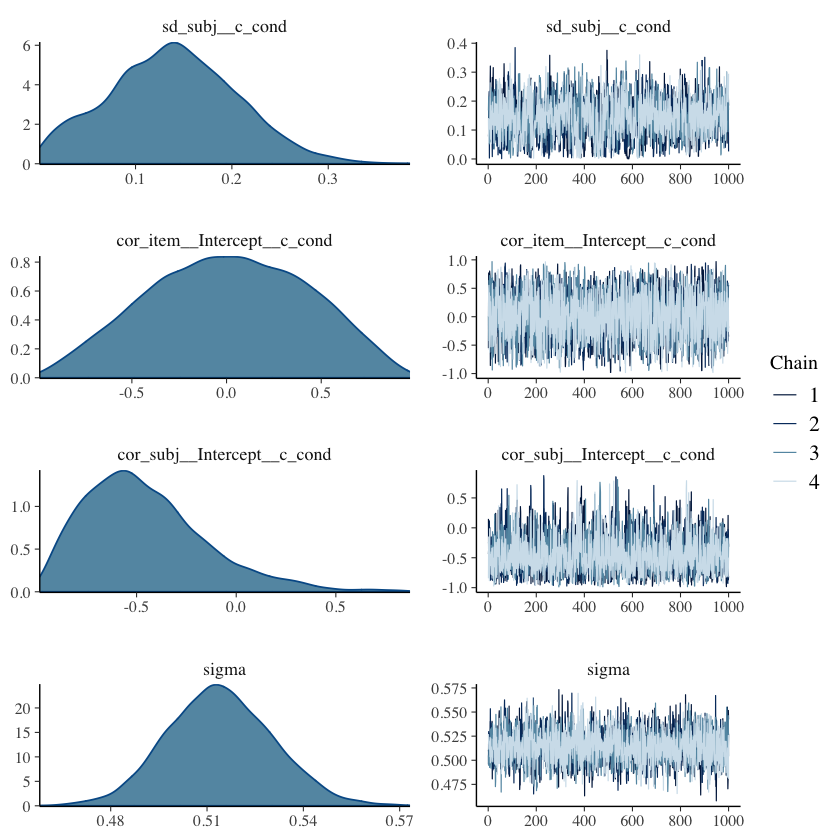

In [89]:
plot(fit_gbw_fulllog)

In [96]:
alpha_samples_norm = as_draws_df(fit_gbw_fullnormal)$b_Intercept
beta_samples_norm <- as_draws_df(fit_gbw_fullnormal)$b_c_cond
rt_diff_norm = beta_samples_norm
stats = c(mean_effect = mean(beta_samples_norm),
quantile(rt_diff_norm, prob=c(0.025,0.975)))
print(stats)

mean_effect        2.5%       97.5% 
  -114.2418   -252.1005     24.6357 


In [95]:
alpha_samples <- as_draws_df(fit_gbw_fulllog)$b_Intercept 
beta_samples <- as_draws_df(fit_gbw_fulllog)$b_c_cond

rt_diff_log <- 
    exp(alpha_samples + 0.5*beta_samples) - exp(alpha_samples - 0.5*beta_samples)
    
stats = c(mean_median_effect = mean(rt_diff_log),
    quantile(rt_diff_log, c(0.025, 0.975)))

print(stats)

mean_median_effect               2.5%              97.5% 
         -32.04041          -82.22732           15.04211 


In [97]:
summary(fit_gbw_fulllog)

 Family: lognormal 
  Links: mu = identity; sigma = identity 
Formula: rt ~ c_cond + (1 + c_cond | subj) + (c_cond | item) 
   Data: df_gibsonwu (Number of observations: 547) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Group-Level Effects: 
~item (Number of levels: 15) 
                      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)             0.21      0.05     0.12     0.33 1.00      988
sd(c_cond)                0.07      0.06     0.00     0.21 1.00     1771
cor(Intercept,c_cond)     0.01      0.42    -0.77     0.78 1.00     3375
                      Tail_ESS
sd(Intercept)             1733
sd(c_cond)                1422
cor(Intercept,c_cond)     2591

~subj (Number of levels: 37) 
                      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)             0.25      0.04     0.18     0.33 1.00     1298
sd(c_cond)                0.14      0.07     0.02     0.27 1.00     117

To better fit future model based on current results, I will chose the likelihood on b as: norm(-0.07, 0.06)

#### Compare results from concatenated data and from incremental knowledge building:

##### Incremental:

In [99]:
# informative priors form 1 study:

priors_maximal_log_inf = c(
    prior(normal(6,0.6), class = Intercept),
    prior(normal(-0.07,0.06), class = b, coef=c_cond),
    prior(normal(0,1), class = sigma),
    prior(normal(0,1), class=sd),
    prior(lkj(2), class = cor)
)

fit_gbw_fulllog_inf <- brm(rt ~ c_cond + (1+ c_cond | subj) + (c_cond | item),
  family=lognormal(),
  prior = priors_maximal_log_inf,
  data = df_gibsonwu2
)

Compiling Stan program...

Start sampling



In [100]:
summary(fit_gbw_fulllog_inf)

 Family: lognormal 
  Links: mu = identity; sigma = identity 
Formula: rt ~ c_cond + (1 + c_cond | subj) + (c_cond | item) 
   Data: df_gibsonwu2 (Number of observations: 595) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Group-Level Effects: 
~item (Number of levels: 15) 
                      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)             0.16      0.04     0.10     0.26 1.00     1138
sd(c_cond)                0.18      0.06     0.07     0.32 1.00     1170
cor(Intercept,c_cond)    -0.42      0.28    -0.88     0.20 1.00     2191
                      Tail_ESS
sd(Intercept)             2162
sd(c_cond)                1570
cor(Intercept,c_cond)     2422

~subj (Number of levels: 40) 
                      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)             0.25      0.04     0.18     0.33 1.00     1132
sd(c_cond)                0.10      0.06     0.01     0.23 1.00     10

##### Concatenated data:

In [101]:
head(df_gibsonwu)
head(df_gibsonwu2)

subj item type     rt   c_cond
94  1    13   obj-ext  1561  0.5  
221 1     6   subj-ext  959 -0.5  
341 1     5   obj-ext   582  0.5  
461 1     9   obj-ext   294  0.5  
621 1    14   subj-ext  438 -0.5  
753 1     4   subj-ext  286 -0.5

subj item condition pos rt   region    c_cond
9  1m1  15   obj-ext   8    832 head noun  0.5  
20 1m1   8   subj-ext  8   2131 head noun -0.5  
33 1m1  11   obj-ext   8    553 head noun  0.5  
46 1m1  10   subj-ext  8   1091 head noun -0.5  
62 1m1  16   subj-ext  8    598 head noun -0.5  
75 1m1  14   subj-ext  8    645 head noun -0.5

In [110]:
df_gibs_1 = df_gibsonwu
df_gibs_2 = df_gibsonwu2[,c(1,2,3,5,7)]
colnames(df_gibs_2)[3] = "type"

pooled_df = rbind(df_gibs_1, df_gibs_2)
head(pooled_df)

subj item type     rt   c_cond
94  1    13   obj-ext  1561  0.5  
221 1     6   subj-ext  959 -0.5  
341 1     5   obj-ext   582  0.5  
461 1     9   obj-ext   294  0.5  
621 1    14   subj-ext  438 -0.5  
753 1     4   subj-ext  286 -0.5

In [108]:
# non-informative priors on pooled data:

priors_maximal_log = c(
    prior(normal(6,0.6), class = Intercept),
    prior(normal(0,1), class = b, coef=c_cond),
    prior(normal(0,1), class = sigma),
    prior(normal(0,1), class=sd),
    prior(lkj(2), class = cor)
)

fit_gbw_fulllog_pooled <- brm(rt ~ c_cond + (1+ c_cond | subj) + (c_cond | item),
  family=lognormal(),
  prior = priors_maximal_log,
  data = pooled_df
)

Compiling Stan program...

Start sampling



In [109]:
summary(fit_gbw_fulllog_pooled)

 Family: lognormal 
  Links: mu = identity; sigma = identity 
Formula: rt ~ c_cond + (1 + c_cond | subj) + (c_cond | item) 
   Data: pooled_df (Number of observations: 1142) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Group-Level Effects: 
~item (Number of levels: 15) 
                      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)             0.18      0.04     0.12     0.28 1.00     1380
sd(c_cond)                0.06      0.04     0.00     0.15 1.00     1849
cor(Intercept,c_cond)    -0.24      0.38    -0.86     0.58 1.00     5758
                      Tail_ESS
sd(Intercept)             2253
sd(c_cond)                2050
cor(Intercept,c_cond)     3086

~subj (Number of levels: 77) 
                      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)             0.25      0.03     0.20     0.30 1.00     1686
sd(c_cond)                0.10      0.05     0.01     0.20 1.00     1295